In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

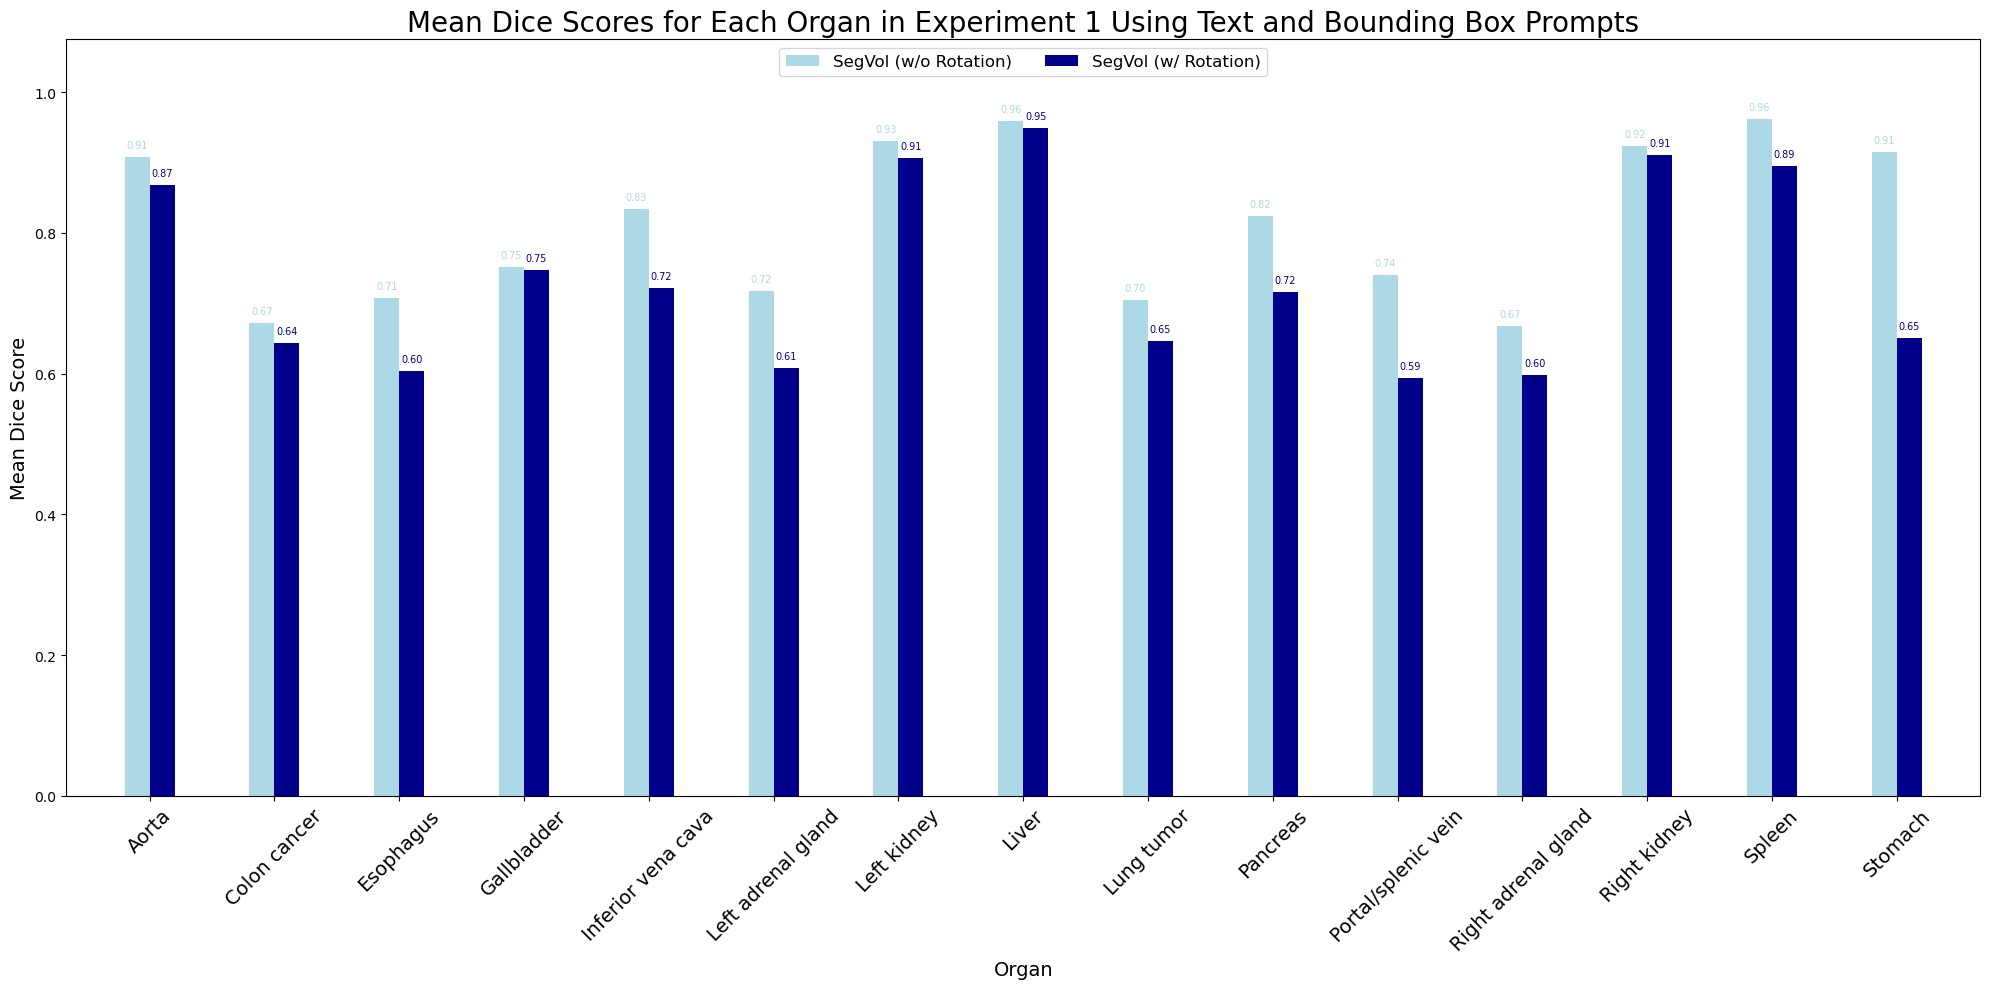

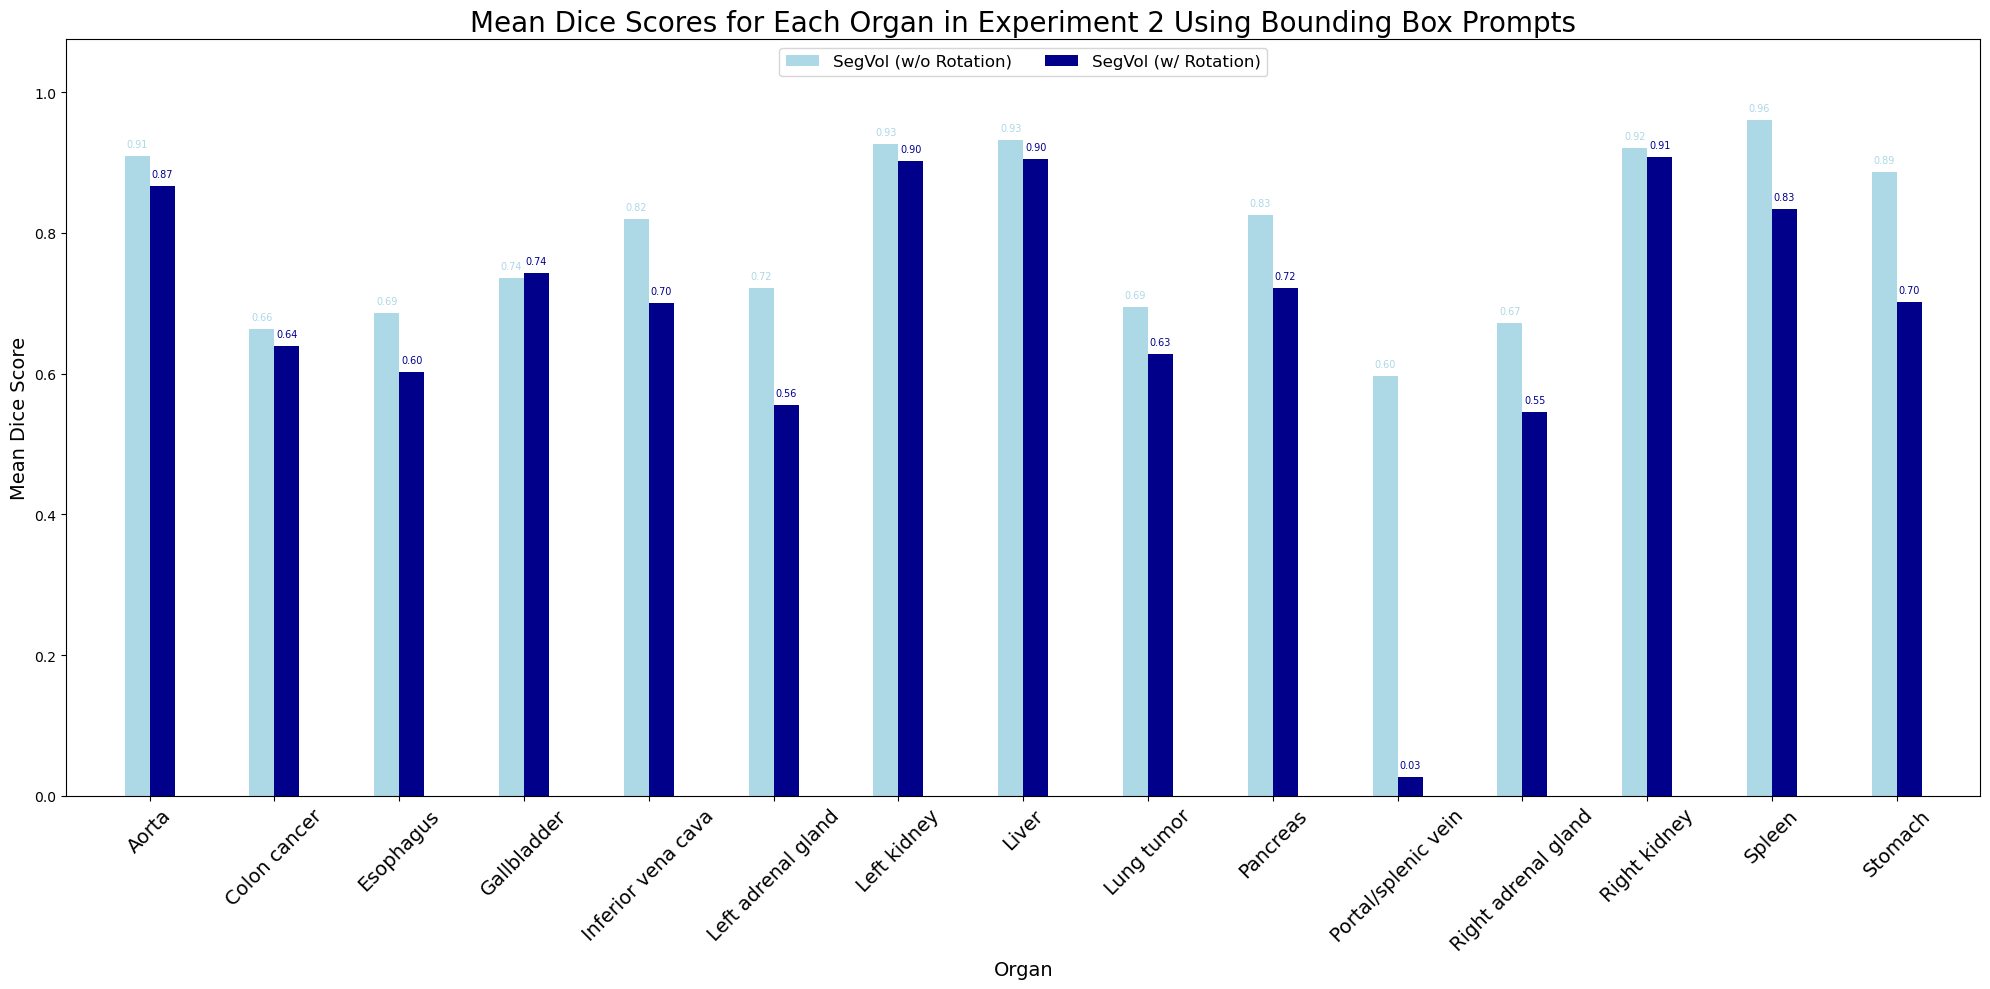

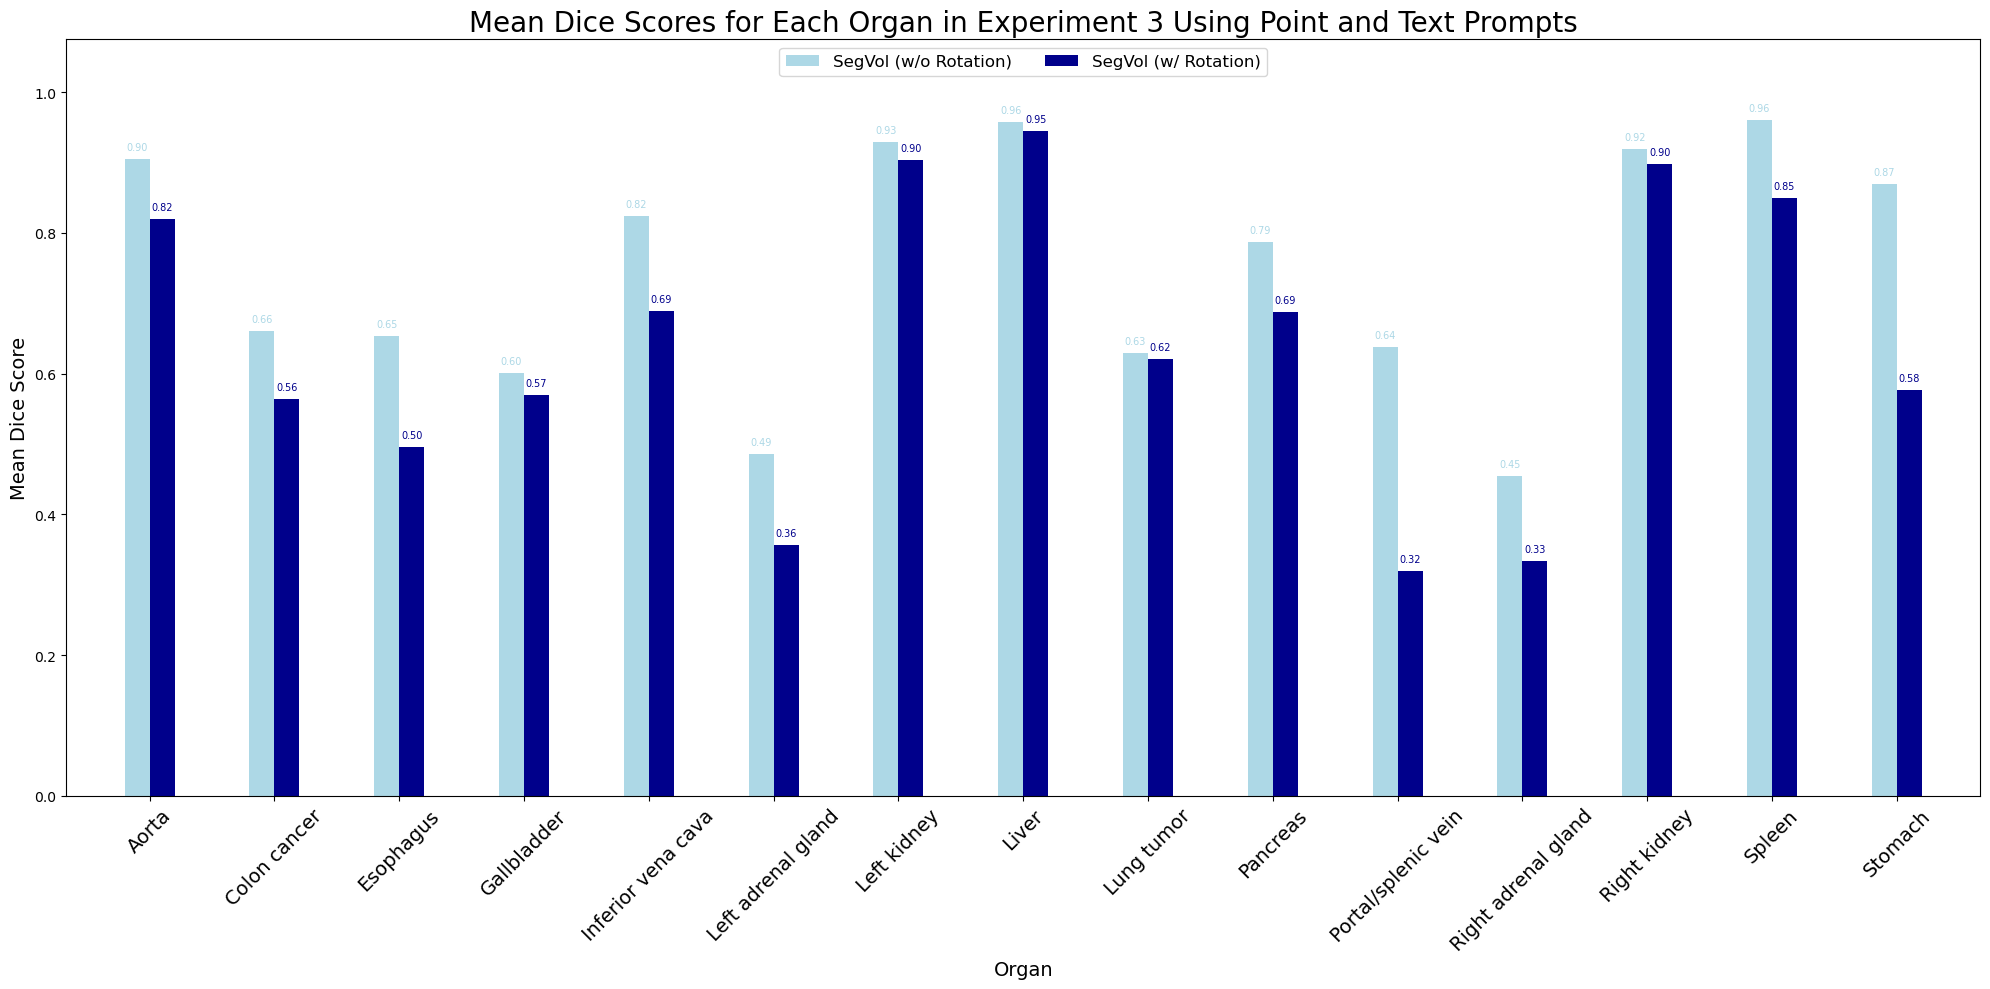

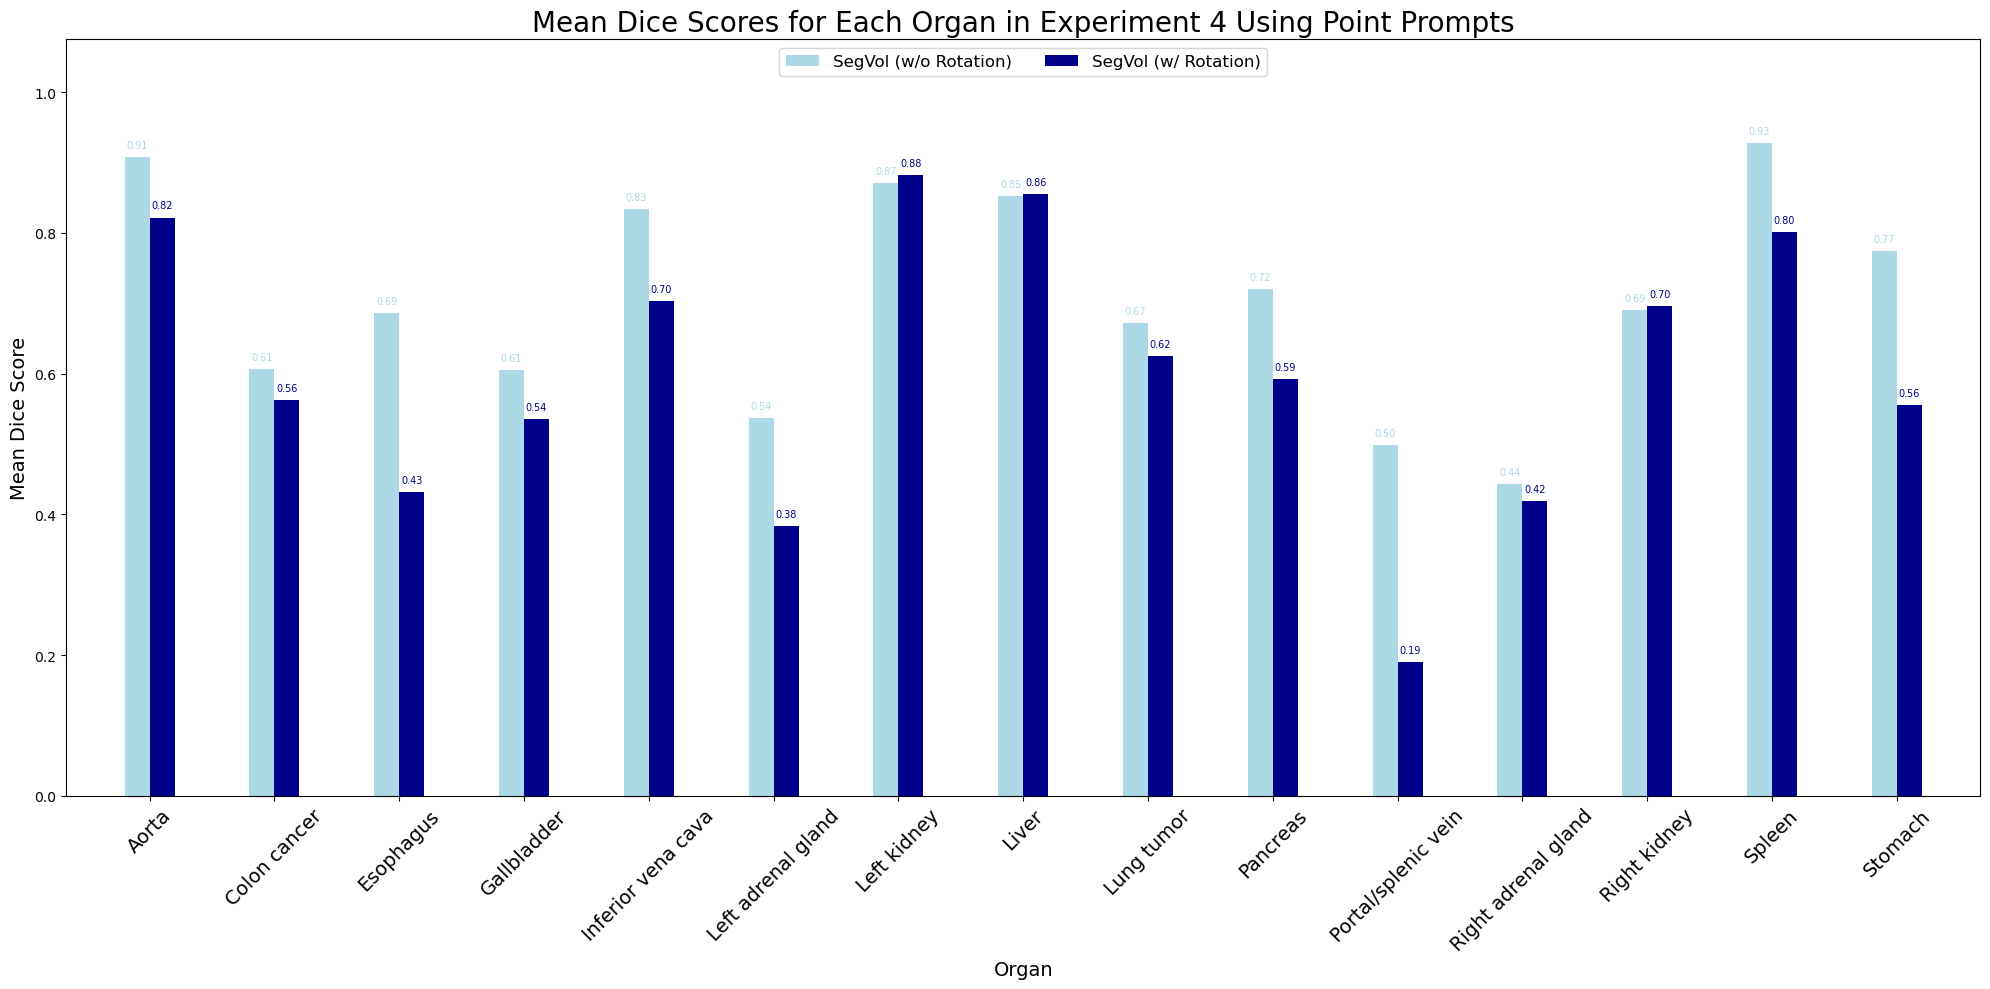

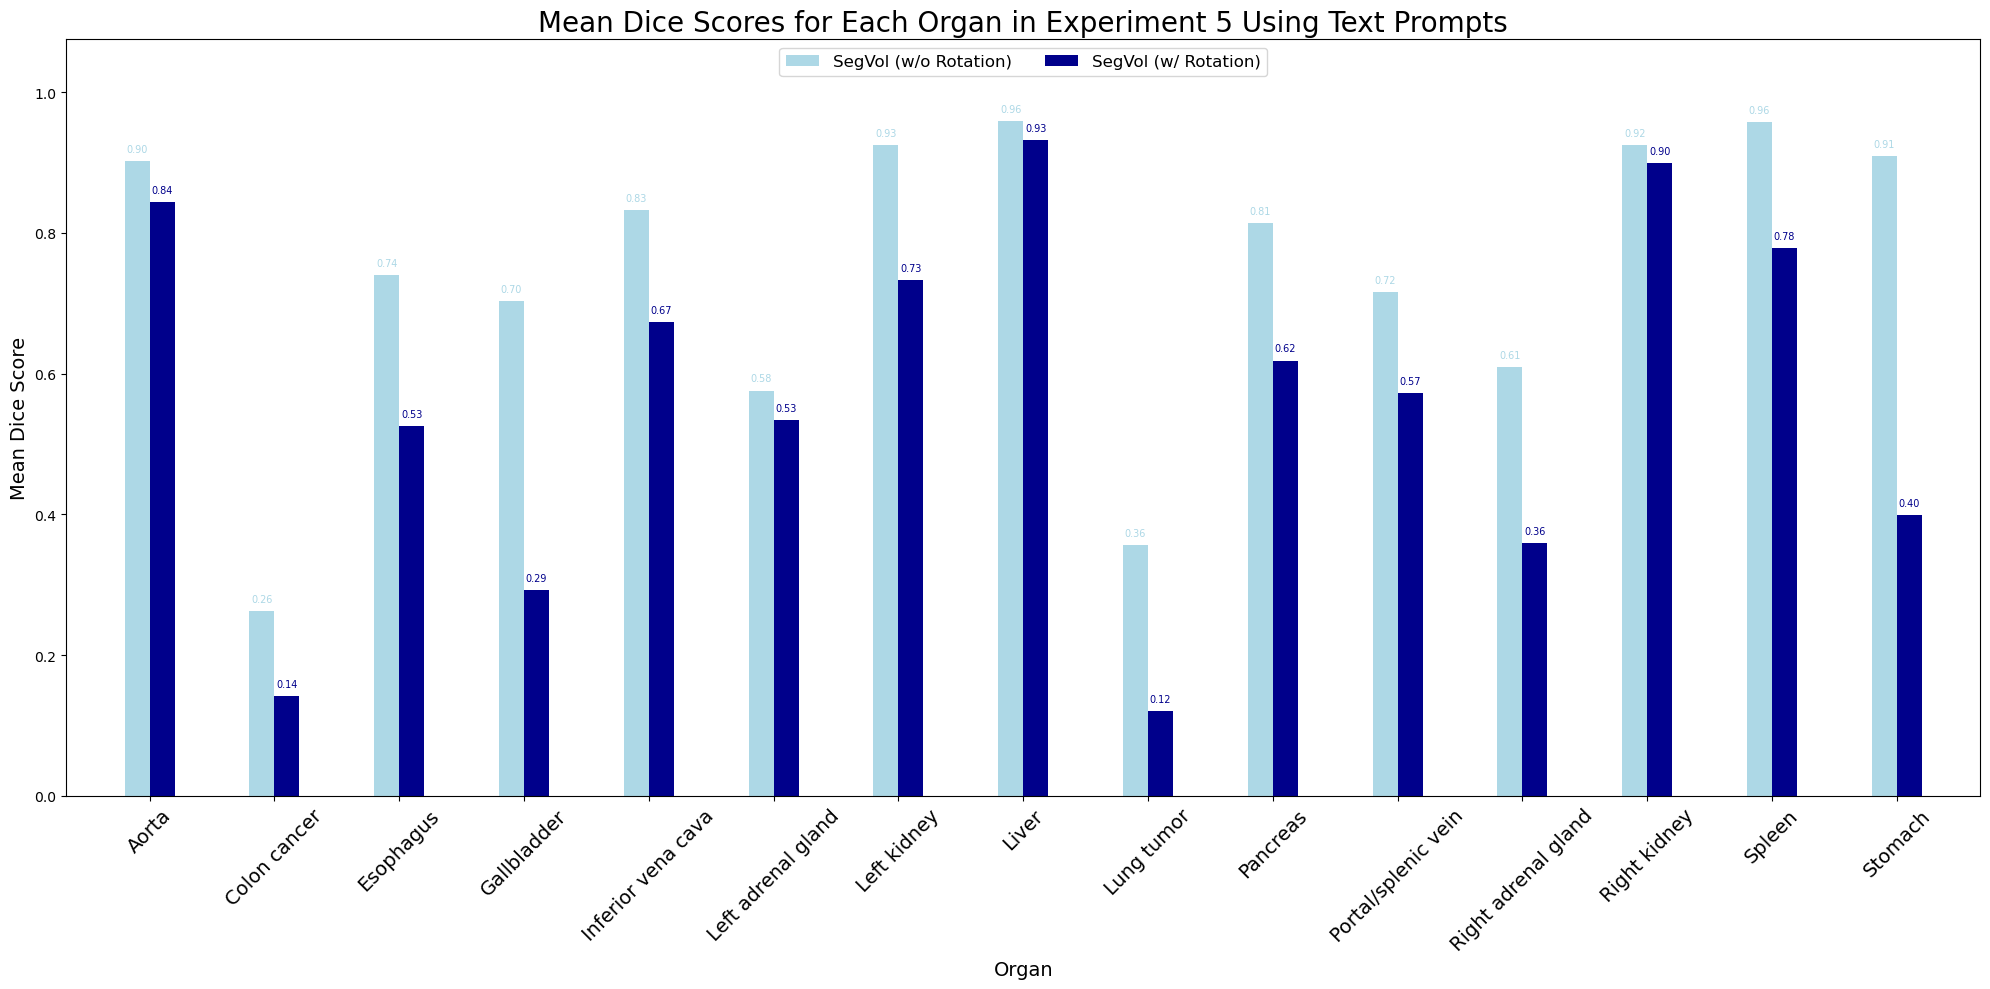

In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

experiment_mapping = {
    2: 'Text and Bounding Box',
    3: 'Bounding Box',
    4: 'Point and Text',
    5: 'Point',
    6: 'Text',
}

dirs = ['SegVol']

def load_data_from_directories(dirs):
    result_frames = []
    for directory in dirs:
        files = os.listdir(directory)
        files = [file for file in files if file.endswith('.csv')]
        
        for file in files:
            no_prefix = file.removeprefix('dice_scores_')
            experiment = no_prefix.split('_')[0]
            exp_nr = int(experiment[3])
            if exp_nr == 1:
                continue
            rotated = (experiment[4] == 'b')

            df = pd.read_csv(os.path.join(directory, file))
            df = df[df['Organ'] != 'Liver tumor']

            df['Rotated'] = rotated
            df['Experiment'] = exp_nr
            df['Directory'] = directory

            dataset_codes = ['0007', '0018', '0020', '0021', '0023']
            scores = []
            for i, row in df.iterrows():
                valid_scores = [df.loc[i, c] for c in dataset_codes if df.loc[i, c] > 0]
                scores.append(np.mean(valid_scores) if valid_scores else np.nan)

            df['Score'] = scores
            result_frames.append(df)

    return pd.concat(result_frames, ignore_index=True)

combined_result_frame = load_data_from_directories(dirs)

for experiment in sorted(combined_result_frame['Experiment'].unique()):
    subset = combined_result_frame[combined_result_frame['Experiment'] == experiment].copy()
    subset = subset.reset_index()

    # Calculate mean scores for each organ
    mean_scores = subset.groupby(['Organ', 'Rotated'])['Score'].mean().unstack(['Rotated'])

    # Plotting
    plt.figure(figsize=(20, 10))
    bar_width = 0.3
    group_width = 1.5
    before_first_bar = 0.5
    after_last_bar = 0.5
    num_bars = len(mean_scores)
    total_width = (num_bars - 1) * group_width + before_first_bar + after_last_bar

    bar_positions = [before_first_bar + i * group_width for i in range(num_bars)]
    pos_dict = {
        False: [-0.5 * bar_width, 'lightblue', 'SegVol (w/o Rotation)'],
        True: [0.5 * bar_width, 'darkblue', 'SegVol (w/ Rotation)']
    }

    for key, (offset, color, label) in pos_dict.items():
        
        if key in mean_scores.columns:

            positions = [x + offset for x in bar_positions]

            plt.bar(positions, mean_scores[key].values, color=color, width=bar_width, label=label)

            # Annotate the bars with the mean values
            for i, value in enumerate(mean_scores[key].values):
                if not pd.isna(value):
                    plt.text(positions[i], value + 0.01, f'{value:.2f}', ha='center', va='bottom', color=color, fontsize=7)

    plt.xlabel('Organ', fontsize=14)
    plt.ylabel('Mean Dice Score', fontsize=14)
    plt.title(f"Mean Dice Scores for Each Organ in Experiment {experiment - 1} Using {experiment_mapping[experiment]} Prompts", fontsize=20)
    plt.xticks(bar_positions, mean_scores.index.get_level_values('Organ'), rotation=45, fontsize=14)
    plt.legend(ncol=2, loc='upper center', bbox_to_anchor=(0.5, 1.0), fontsize=12)
    plt.xlim(-before_first_bar, total_width - after_last_bar + 1)
    plt.ylim(0, 1.075)
    plt.tight_layout()
    plt.savefig(f'../../figures/experiment_{experiment - 1}_dice_scores_{dirs[0]}.png')
    plt.show()

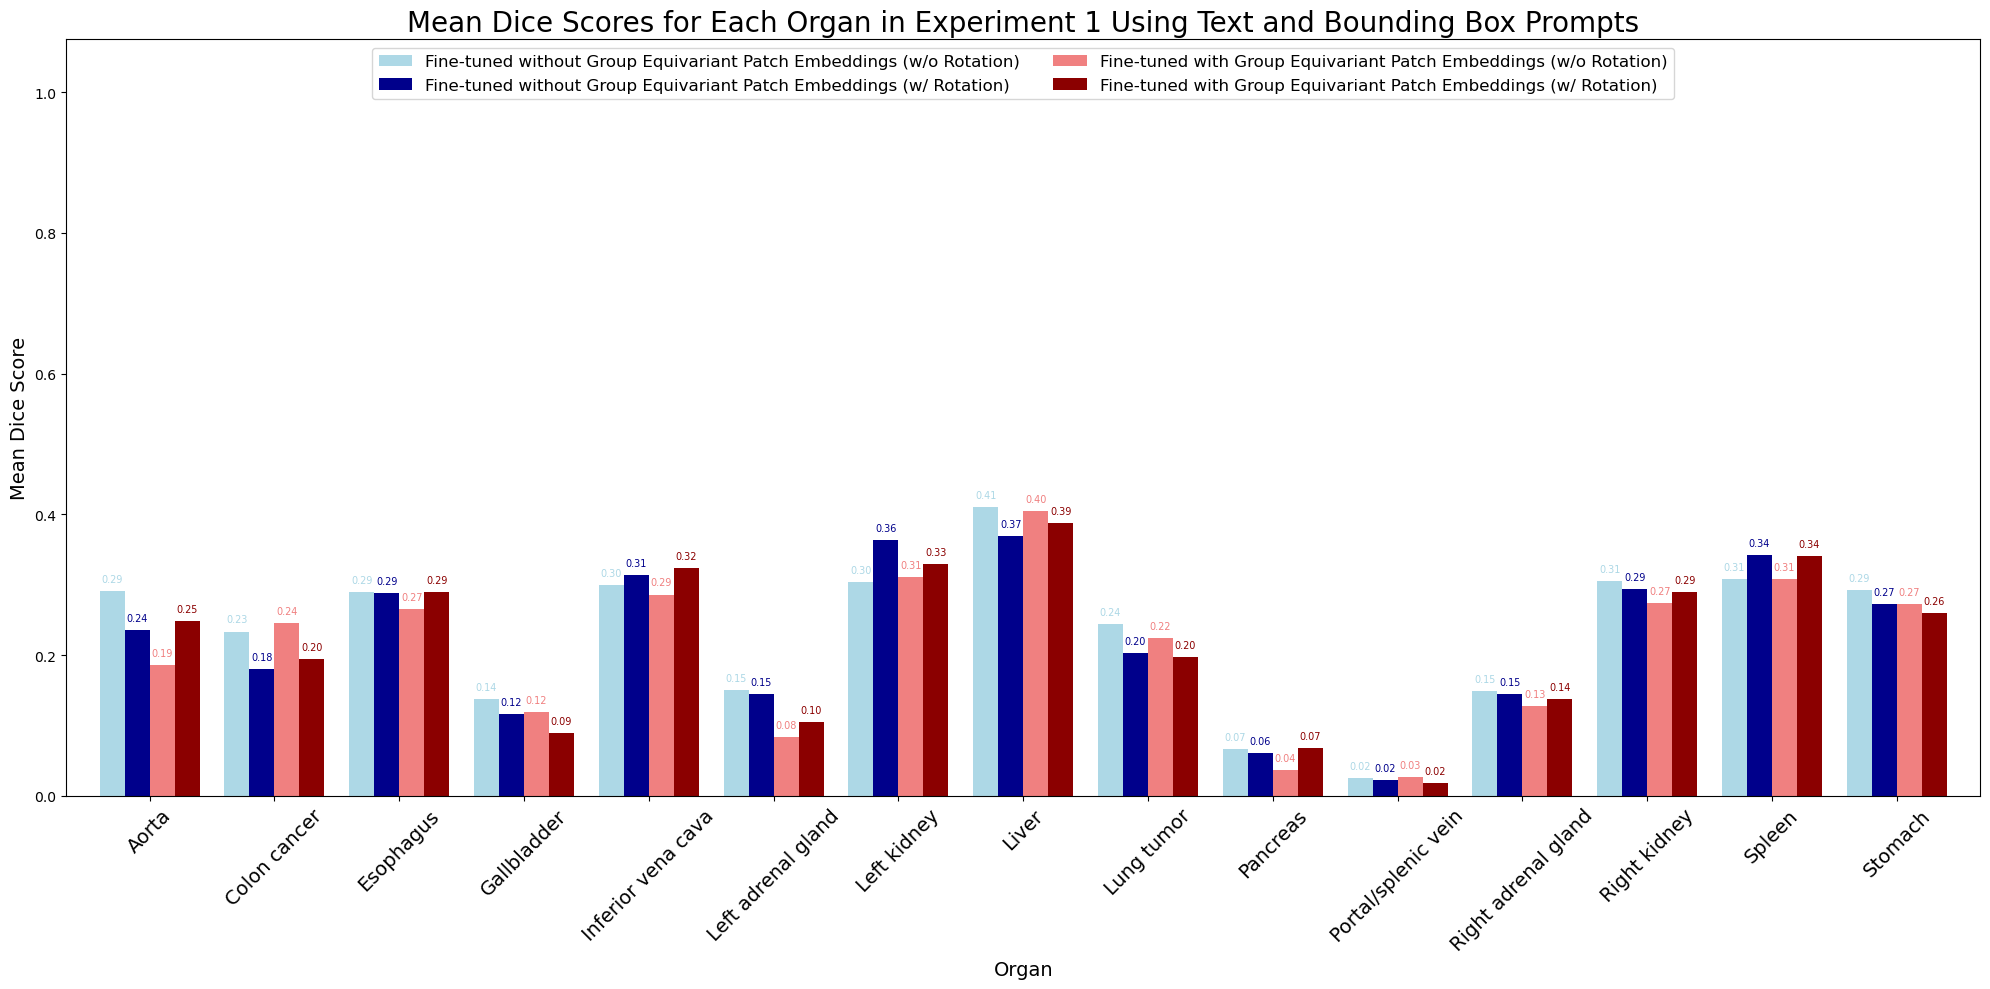

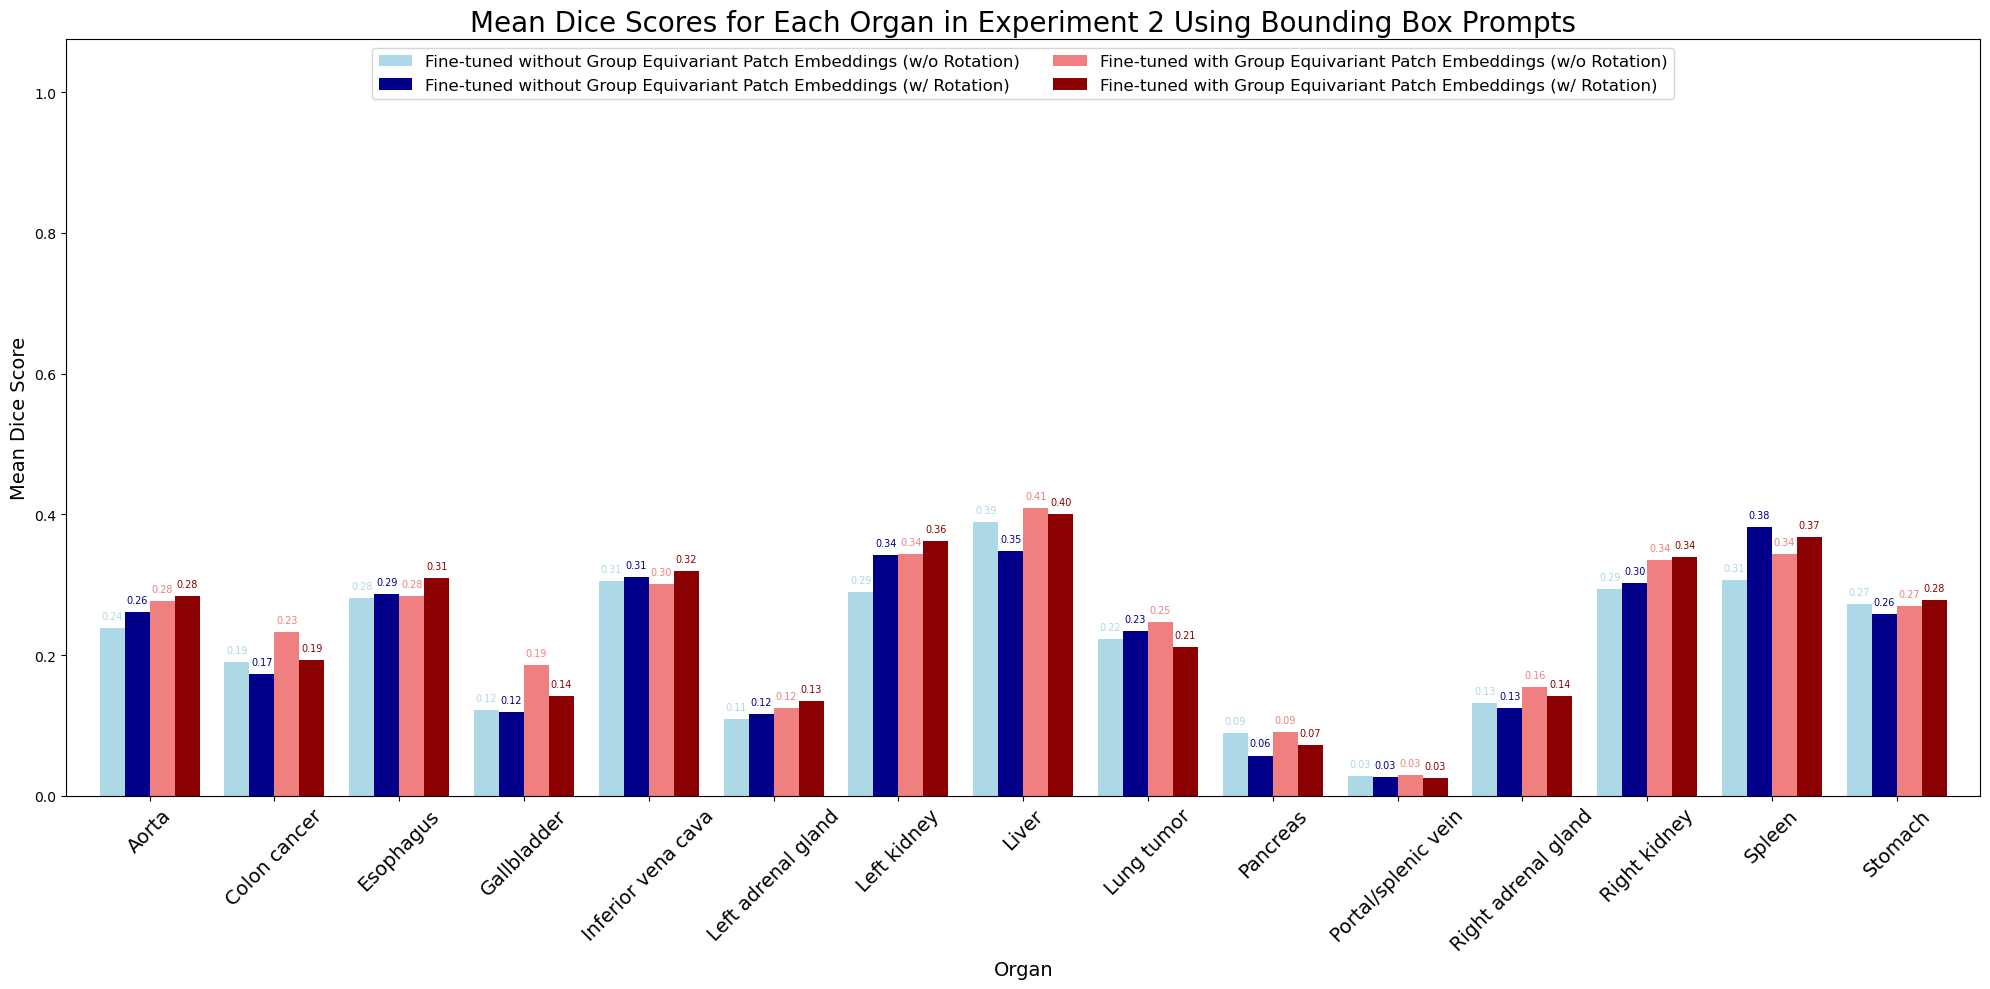

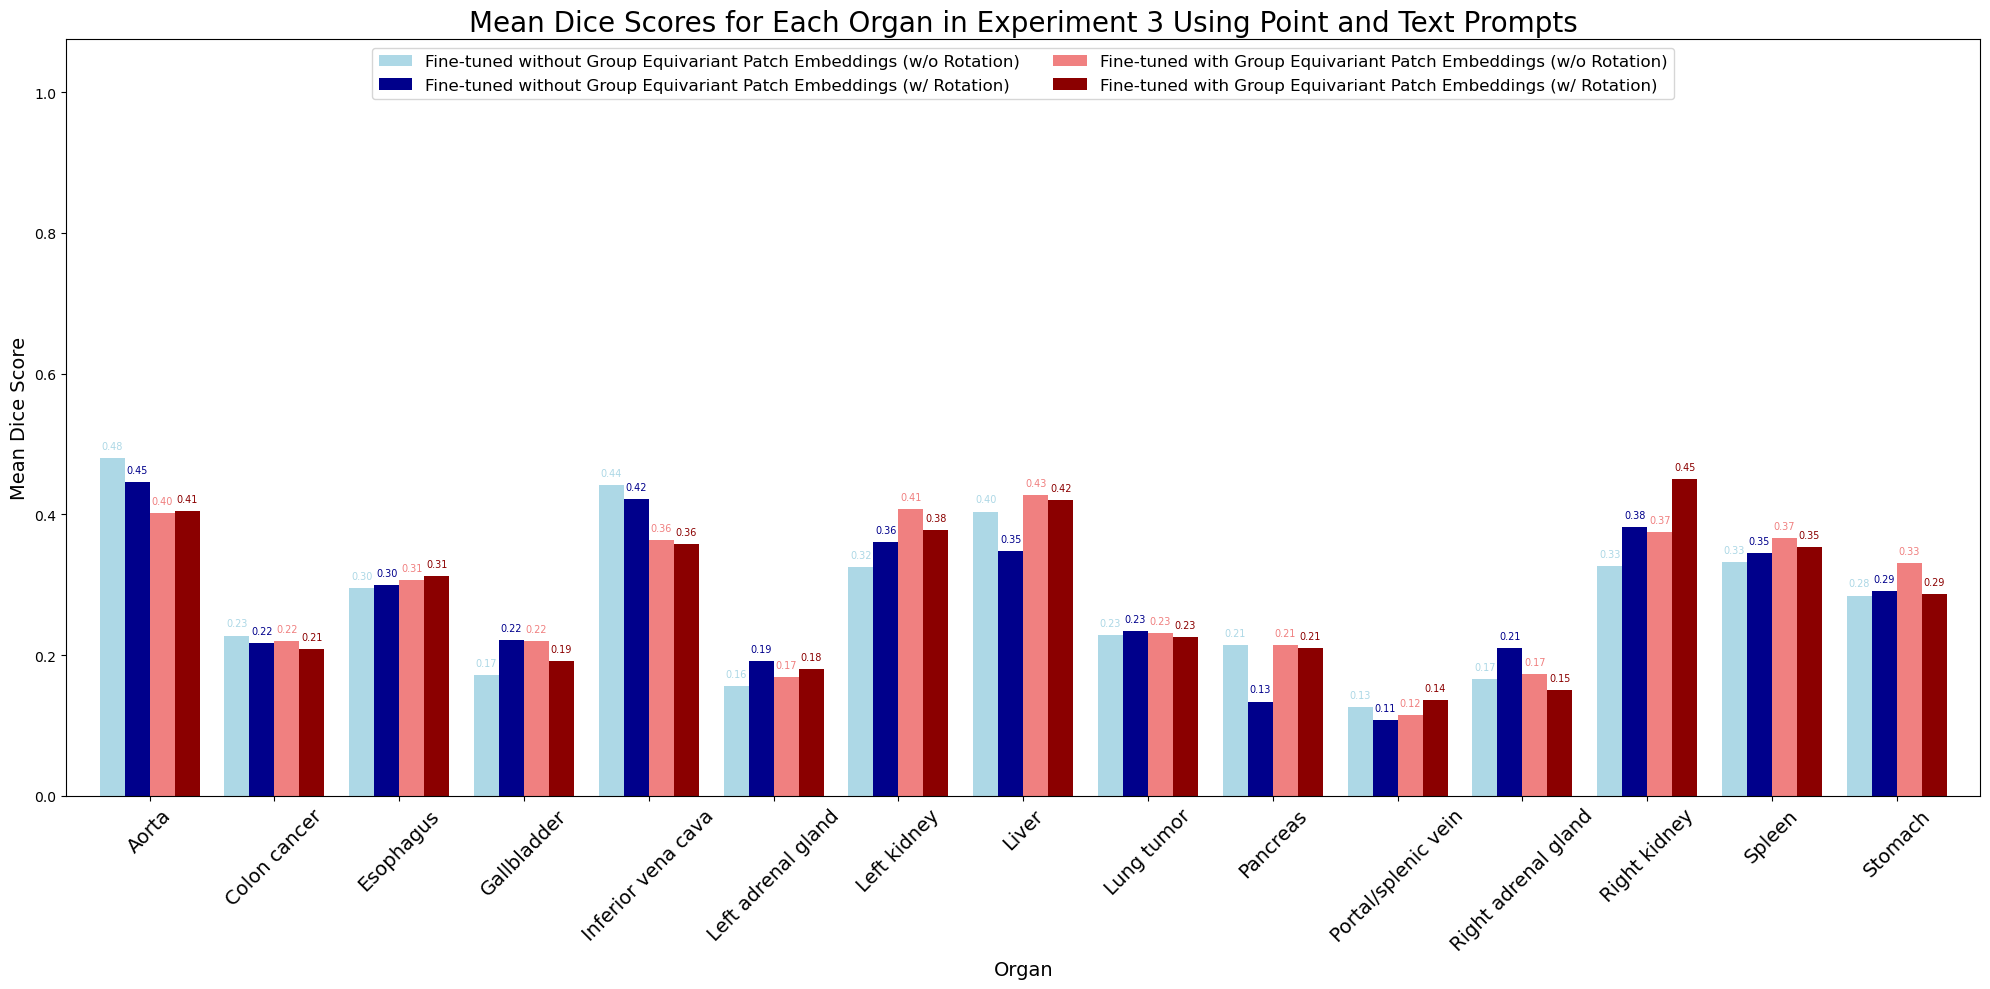

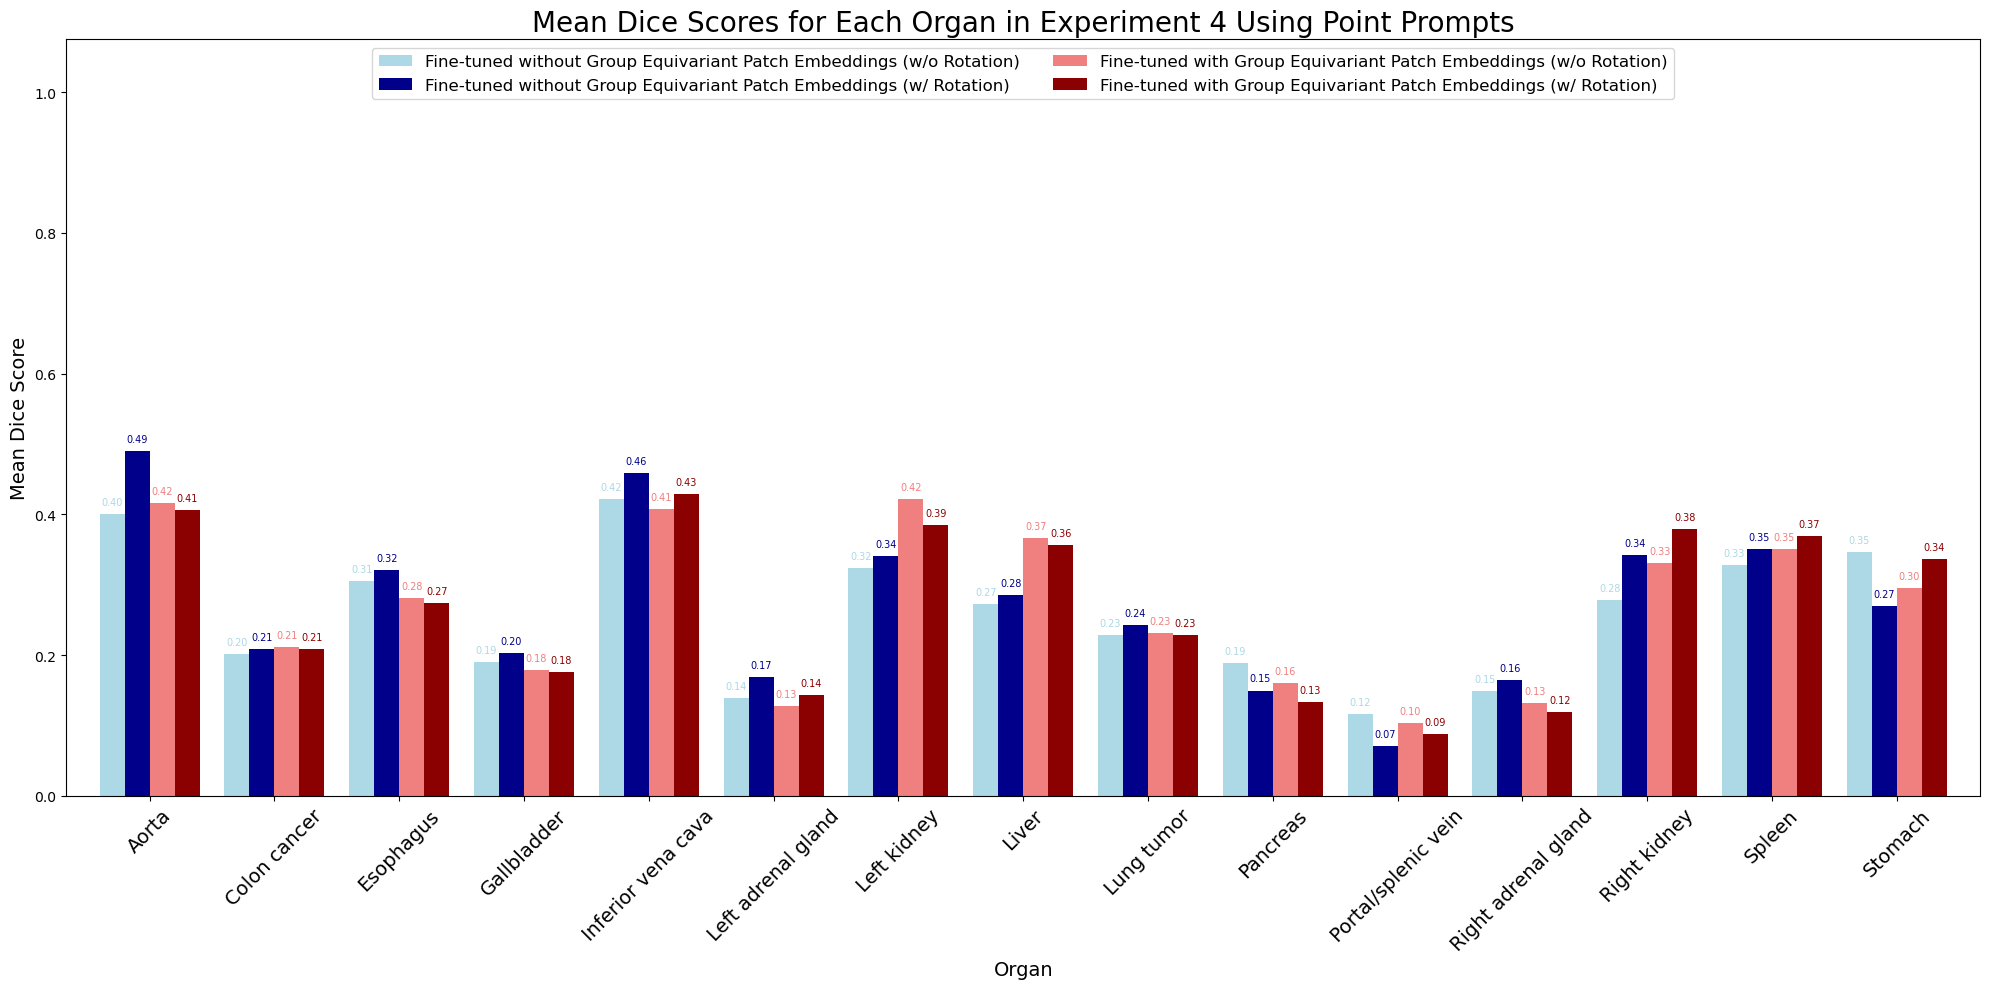

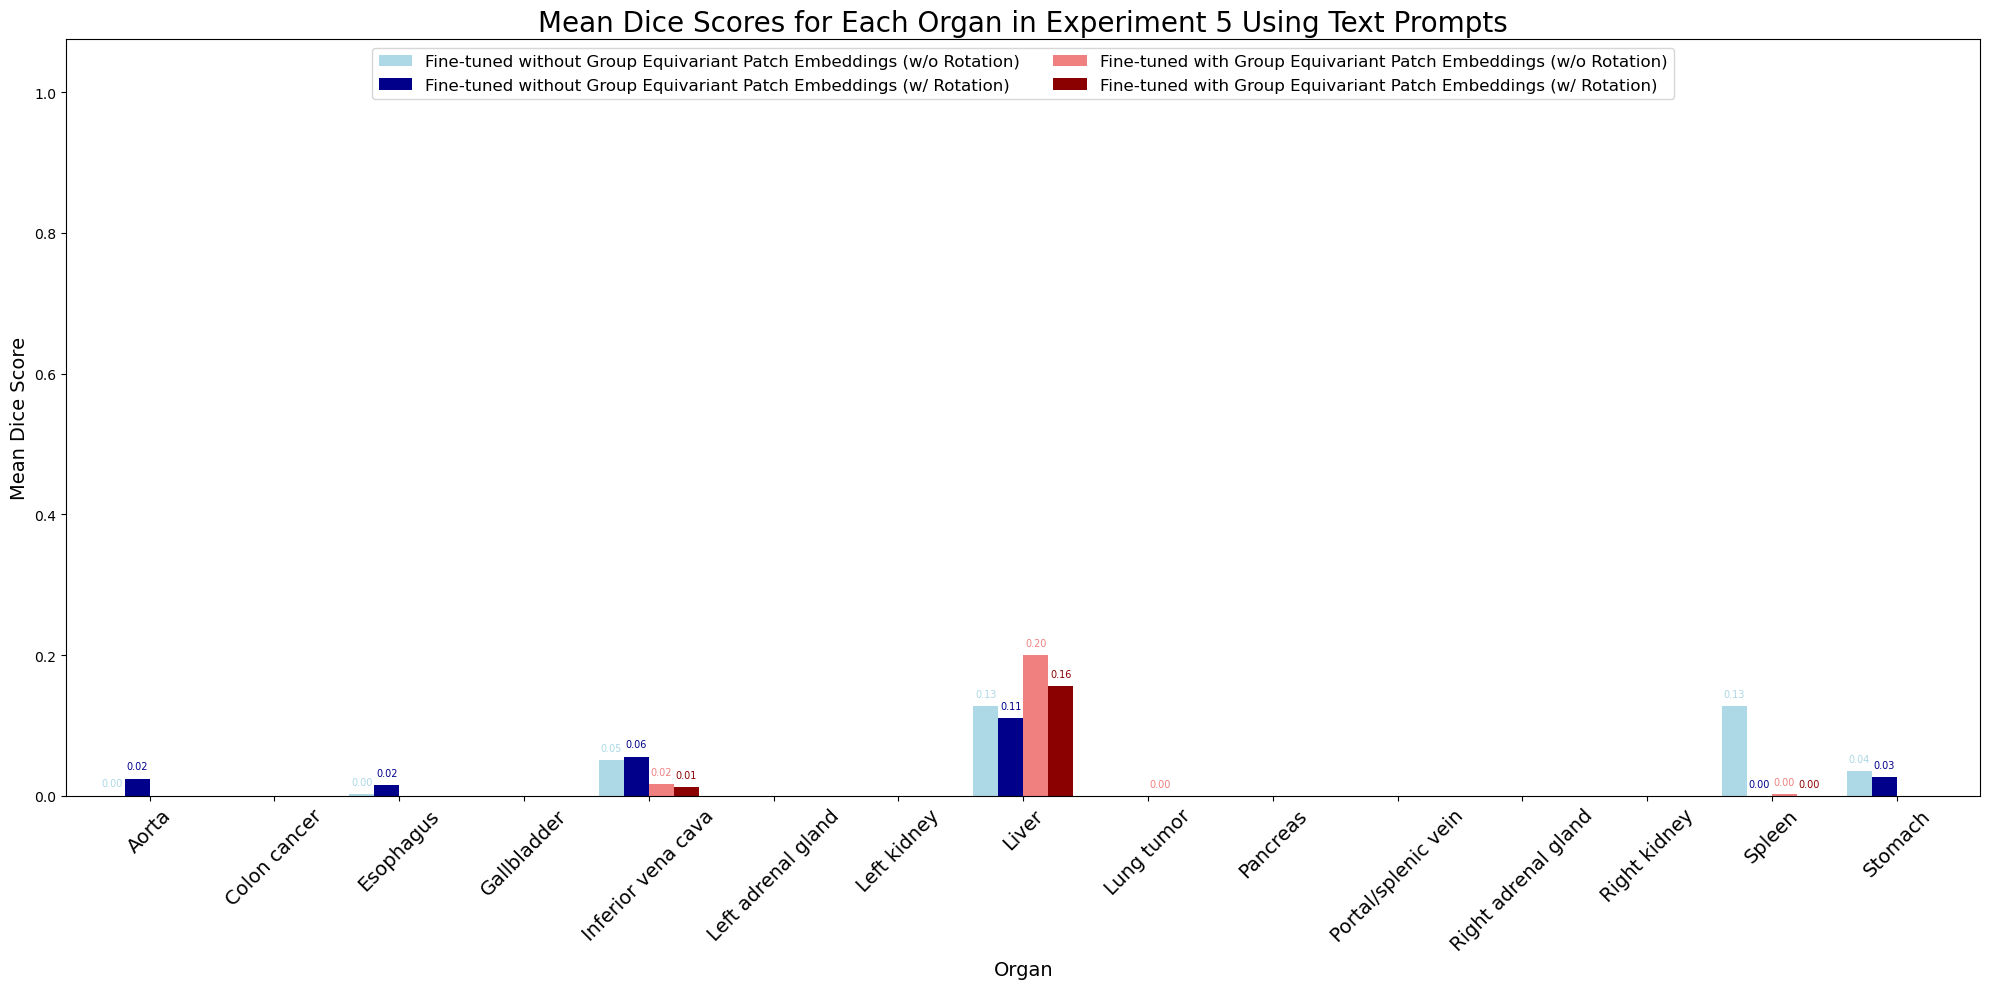

In [3]:
experiment_mapping = {
    2: 'Text and Bounding Box',
    3: 'Bounding Box',
    4: 'Point and Text',
    5: 'Point',
    6: 'Text',
}

dirs = ['baseline_30_epochs', 'ft_25_epochs'] 

def load_data_from_directories(dirs):
    result_frames = []
    for directory in dirs:
        files = os.listdir(directory)
        files = [file for file in files if file.endswith('.csv')]
        
        for file in files:
            no_prefix = file.removeprefix('dice_scores_')
            experiment = no_prefix.split('_')[0]
            exp_nr = int(experiment[3])
            if exp_nr == 1:
                continue
            rotated = (experiment[4] == 'b')

            df = pd.read_csv(os.path.join(directory, file))
            df = df[df['Organ'] != 'Liver tumor']

            df['Rotated'] = rotated
            df['Experiment'] = exp_nr
            df['Directory'] = directory  # Add directory info

            dataset_codes = ['0007', '0018', '0020', '0021', '0023']
            scores = []
            for i, row in df.iterrows():
                valid_scores = [df.loc[i, c] for c in dataset_codes if df.loc[i, c] > 0]
                scores.append(np.mean(valid_scores) if valid_scores else np.nan)

            df['Score'] = scores
            result_frames.append(df)

    return pd.concat(result_frames, ignore_index=True)

combined_result_frame = load_data_from_directories(dirs)

for experiment in sorted(combined_result_frame['Experiment'].unique()):
    subset = combined_result_frame[combined_result_frame['Experiment'] == experiment].copy()
    subset = subset.reset_index()

    # Calculate mean scores for each organ
    mean_scores = subset.groupby(['Organ', 'Rotated', 'Directory'])['Score'].mean().unstack(['Rotated', 'Directory'])

    # Plotting
    plt.figure(figsize=(20, 10))
    bar_width = 0.3
    group_width = 1.5
    before_first_bar = 0.5
    after_last_bar = 0.5
    num_bars = len(mean_scores)
    total_width = (num_bars - 1) * group_width + before_first_bar + after_last_bar

    bar_positions = [before_first_bar + i * group_width for i in range(num_bars)]
    pos_dict = {
        (False, dirs[0]): [-1.5 * bar_width, 'lightblue', 'Fine-tuned without Group Equivariant Patch Embeddings (w/o Rotation)'],
        (True, dirs[0]): [-0.5 * bar_width, 'darkblue', 'Fine-tuned without Group Equivariant Patch Embeddings (w/ Rotation)'],
        (False, dirs[1]): [0.5 * bar_width, 'lightcoral', 'Fine-tuned with Group Equivariant Patch Embeddings (w/o Rotation)'],
        (True, dirs[1]): [1.5 * bar_width, 'darkred', 'Fine-tuned with Group Equivariant Patch Embeddings (w/ Rotation)'],
    }

    for key, (offset, color, label) in pos_dict.items():
        
        if key in mean_scores.columns:

            positions = [x + offset for x in bar_positions]

            plt.bar(positions, mean_scores[key].values, color=color, width=bar_width, label=label)

            # Annotate the bars with the mean values
            for i, value in enumerate(mean_scores[key].values):
                if not pd.isna(value):
                    plt.text(positions[i], value + 0.01, f'{value:.2f}', ha='center', va='bottom', color=color, fontsize=7)

    plt.xlabel('Organ', fontsize=14)
    plt.ylabel('Mean Dice Score', fontsize=14)
    plt.title(f"Mean Dice Scores for Each Organ in Experiment {experiment - 1} Using {experiment_mapping[experiment]} Prompts", fontsize=20)
    plt.xticks(bar_positions, mean_scores.index, rotation=45, fontsize=14)
    plt.legend(ncol=2, loc='upper center', bbox_to_anchor=(0.5, 1.0), fontsize=12)
    plt.xlim(-before_first_bar, total_width - after_last_bar + 1)
    plt.ylim(0, 1.075)
    plt.tight_layout()
    plt.savefig(f'../../figures/experiment_{experiment - 1}_dice_scores_{dirs[0]}_{dirs[1]}.png')
    plt.show()

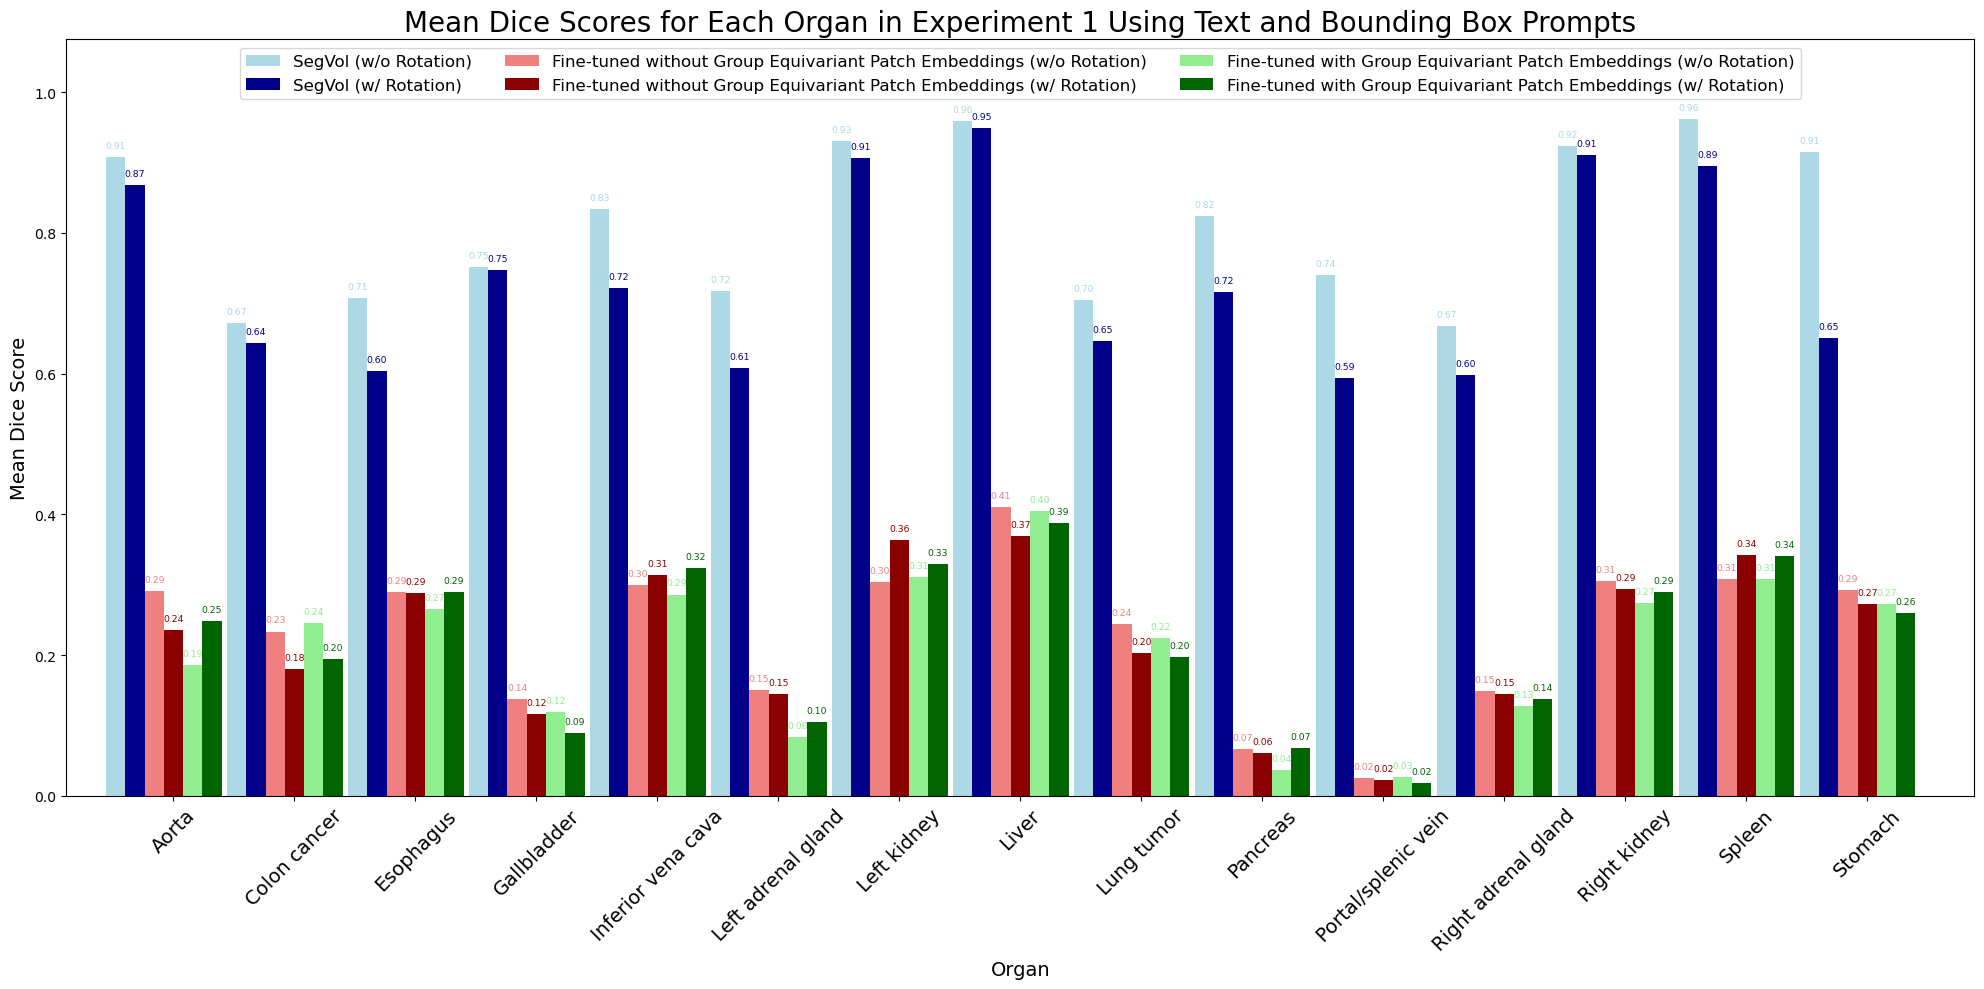

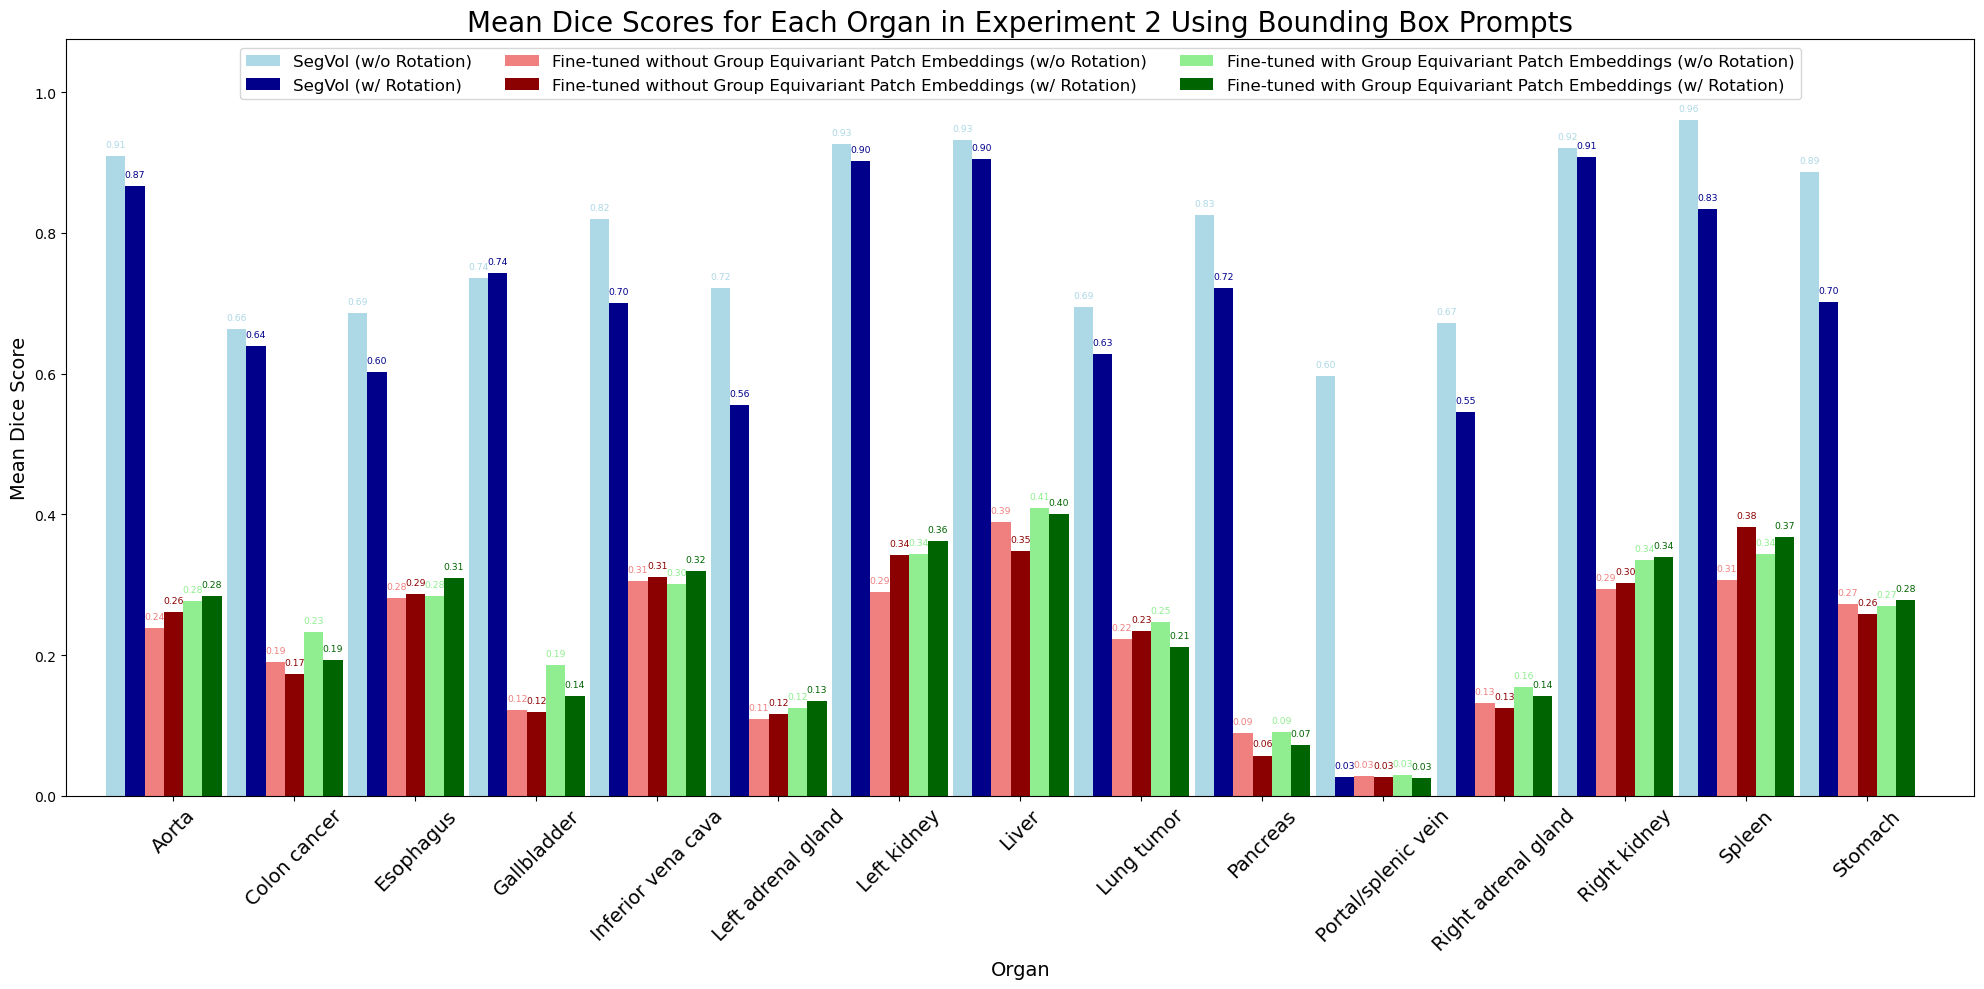

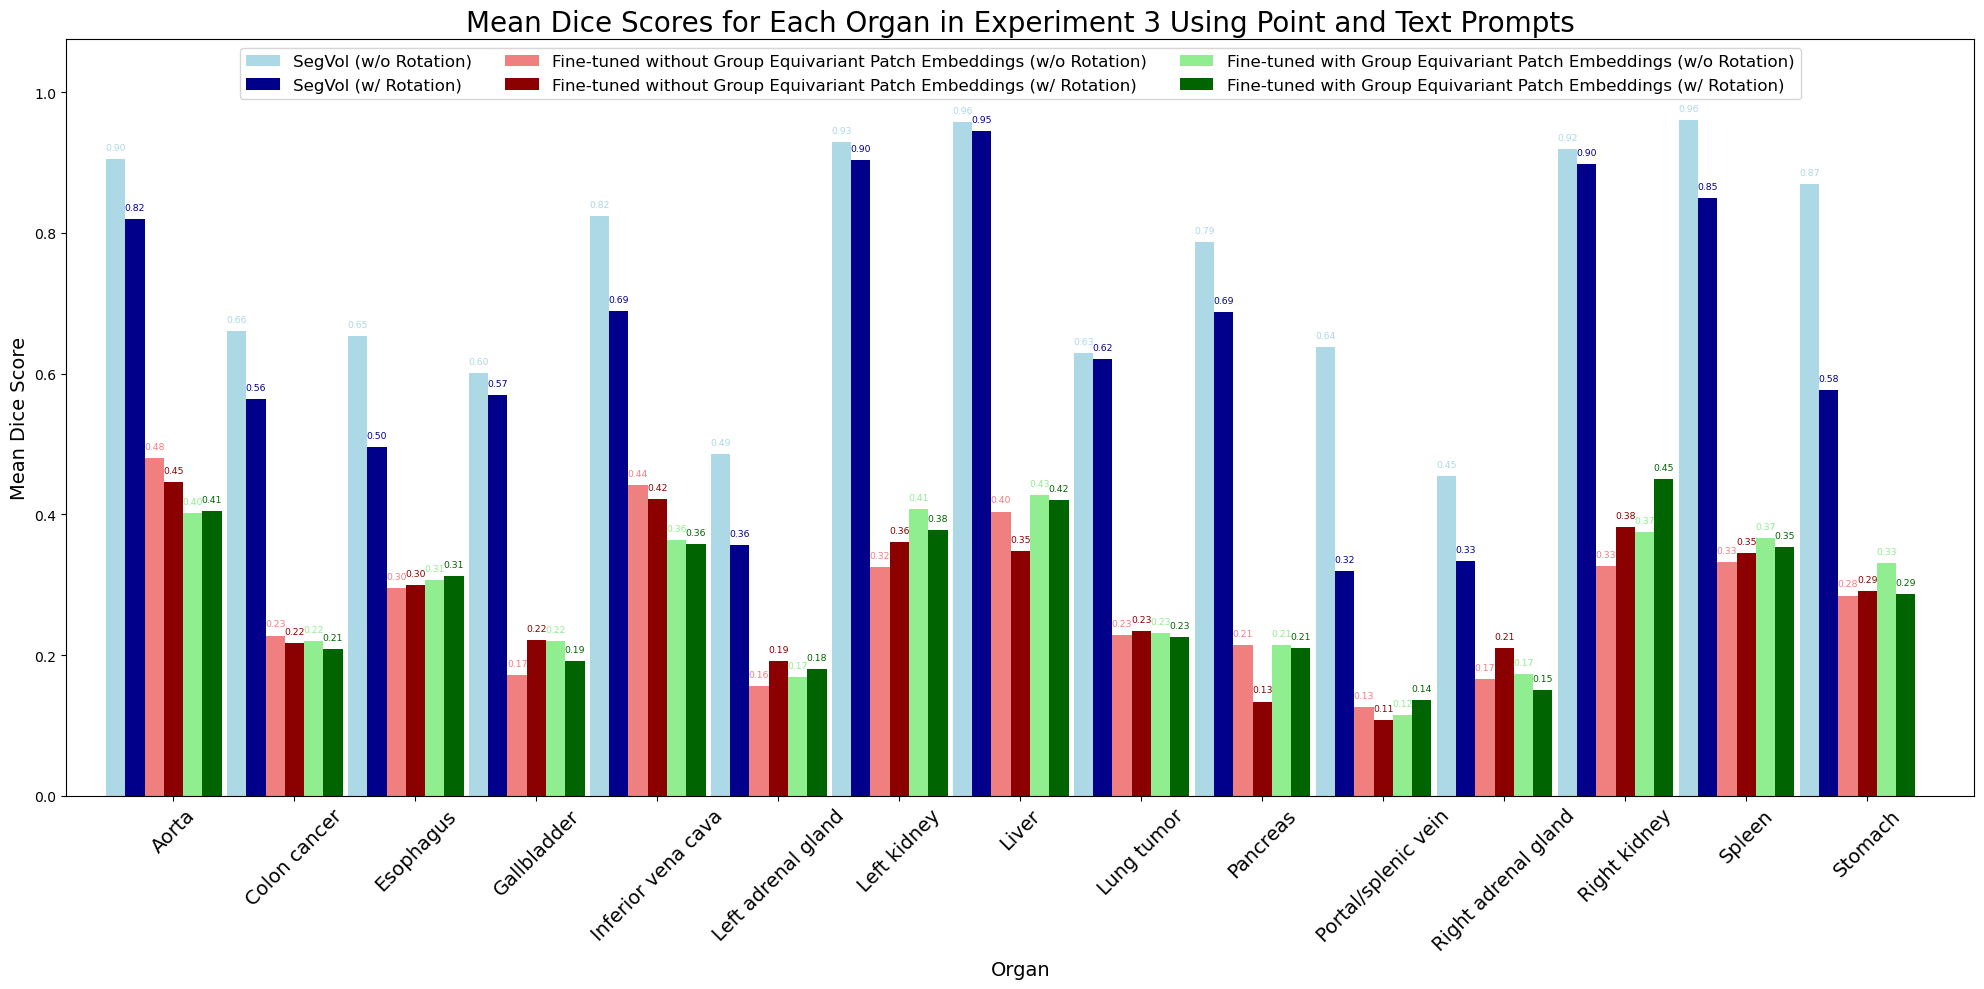

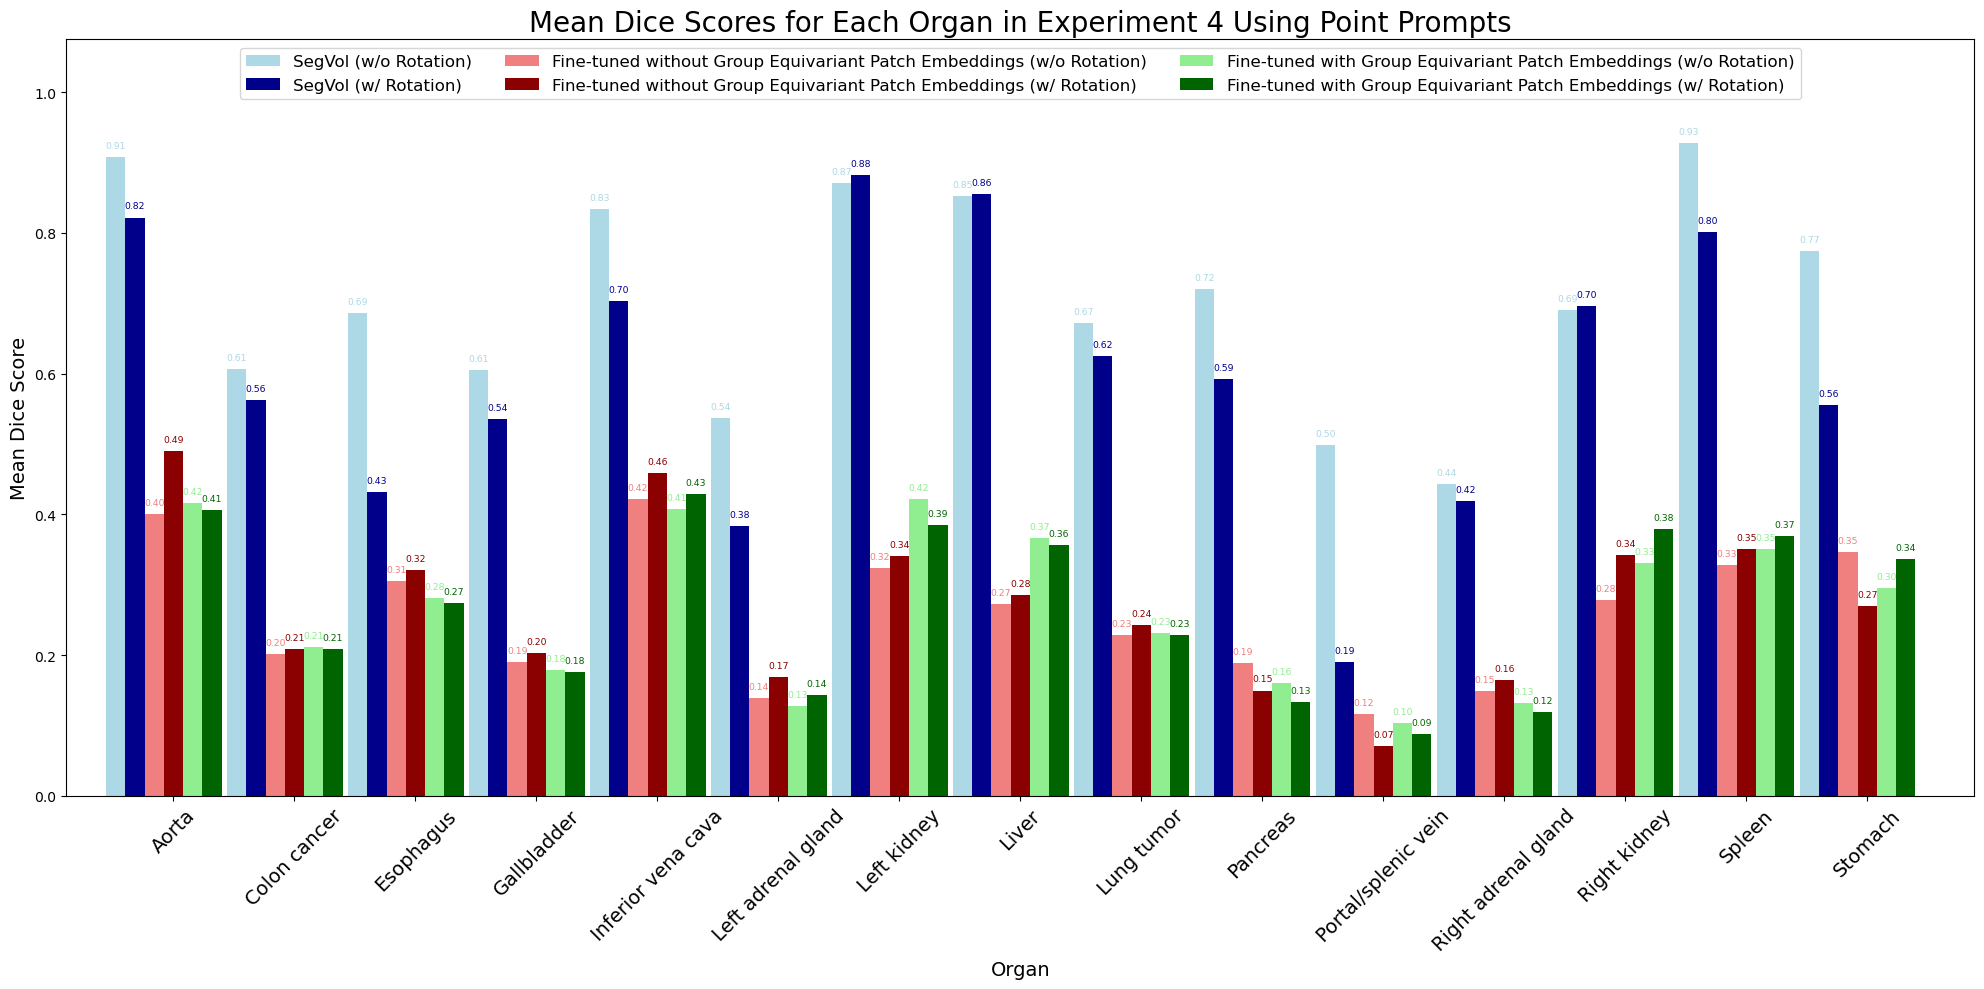

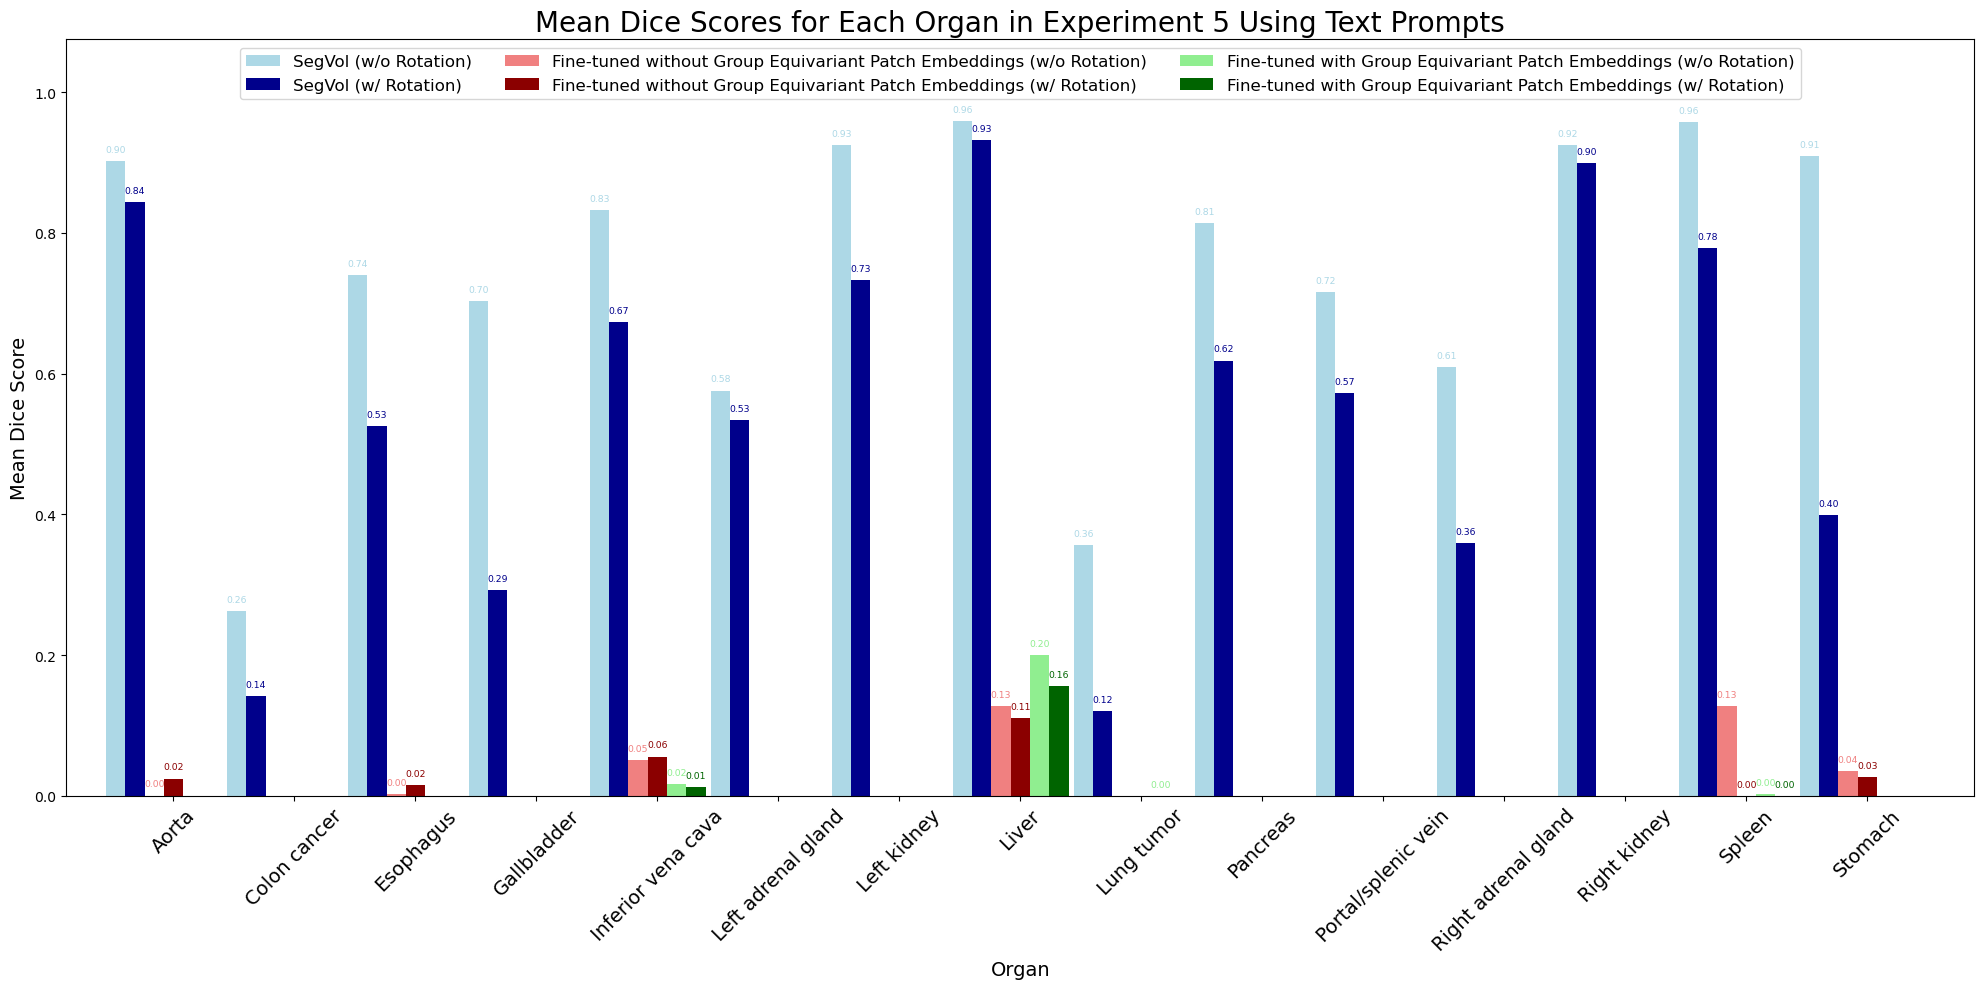

In [4]:
experiment_mapping = {
    2: 'Text and Bounding Box',
    3: 'Bounding Box',
    4: 'Point and Text',
    5: 'Point',
    6: 'Text',
}

dirs = ['SegVol', 'baseline_30_epochs', 'ft_25_epochs']

# Define colors and labels for each directory
colors = ['lightblue', 'darkblue', 'lightcoral', 'darkred', 'lightgreen', 'darkgreen']
labels = ['SegVol (w/o Rotation)', 'SegVol (w/ Rotation)', 
          'Fine-tuned without Group Equivariant Patch Embeddings (w/o Rotation)', 'Fine-tuned without Group Equivariant Patch Embeddings (w/ Rotation)',
          'Fine-tuned with Group Equivariant Patch Embeddings (w/o Rotation)', 'Fine-tuned with Group Equivariant Patch Embeddings (w/ Rotation)']

def load_data_from_directories(dirs):
    result_frames = []
    for directory in dirs:
        files = os.listdir(directory)
        files = [file for file in files if file.endswith('.csv')]
        
        for file in files:
            no_prefix = file.removeprefix('dice_scores_')
            experiment = no_prefix.split('_')[0]
            exp_nr = int(experiment[3])
            if exp_nr == 1:
                continue
            rotated = (experiment[4] == 'b')

            df = pd.read_csv(os.path.join(directory, file))
            df = df[df['Organ'] != 'Liver tumor']

            df['Rotated'] = rotated
            df['Experiment'] = exp_nr
            df['Directory'] = directory  # Add directory info

            dataset_codes = ['0007', '0018', '0020', '0021', '0023']
            scores = []
            for i, row in df.iterrows():
                valid_scores = [df.loc[i, c] for c in dataset_codes if df.loc[i, c] > 0]
                scores.append(np.mean(valid_scores) if valid_scores else np.nan)

            df['Score'] = scores
            result_frames.append(df)
    return pd.concat(result_frames, ignore_index=True)

combined_result_frame = load_data_from_directories(dirs)

for experiment in sorted(combined_result_frame['Experiment'].unique()):
    subset = combined_result_frame[combined_result_frame['Experiment'] == experiment].copy()
    subset = subset.reset_index()

    # Calculate mean scores for each organ
    mean_scores = subset.groupby(['Organ', 'Rotated', 'Directory'])['Score'].mean().unstack(['Rotated', 'Directory'])

    # Plotting
    plt.figure(figsize=(20, 10))
    bar_width = 0.18  # Increase bar width to 0.20
    num_dirs = len(dirs)
    num_conditions = 2  # Rotated and non-rotated
    total_conditions = num_dirs * num_conditions  # Total number of conditions per organ
    group_width = bar_width * total_conditions + 0.05  # Width of each group of bars including a small space between groups
    before_first_bar = 0.5
    after_last_bar = 0.5
    num_bars = len(mean_scores)
    total_width = (num_bars - 1) * group_width + before_first_bar + after_last_bar

    bar_positions = [before_first_bar + i * group_width for i in range(num_bars)]
    pos_dict = {}
    for i, directory in enumerate(dirs):
        pos_dict[(False, directory)] = [(-0.5 * total_conditions + i * num_conditions + 0) * bar_width, colors[i * 2], labels[i * 2]]
        pos_dict[(True, directory)] = [(-0.5 * total_conditions + i * num_conditions + 1) * bar_width, colors[i * 2 + 1], labels[i * 2 + 1]]

    for key, (offset, color, label) in pos_dict.items():
        if key in mean_scores.columns:
            positions = [x + offset for x in bar_positions]
            plt.bar(positions, mean_scores[key].values, color=color, width=bar_width, label=label)

            # Annotate the bars with the mean values
            for i, value in enumerate(mean_scores[key].values):
                if not pd.isna(value):
                    plt.text(positions[i], value + 0.01, f'{value:.2f}', ha='center', va='bottom', color=color, fontsize=6.7)

    plt.xlabel('Organ', fontsize=14)
    plt.ylabel('Mean Dice Score', fontsize=14)
    plt.title(f"Mean Dice Scores for Each Organ in Experiment {experiment - 1} Using {experiment_mapping[experiment]} Prompts", fontsize=20)
    plt.xticks(bar_positions, mean_scores.index, rotation=45, fontsize=14)
    plt.legend(ncol=3, loc='upper center', bbox_to_anchor=(0.5, 1.0), fontsize=12)
    plt.xlim(-before_first_bar, total_width - after_last_bar + 1)
    plt.ylim(0, 1.075)
    plt.tight_layout()
    plt.savefig(f'../../figures/experiment_{experiment - 1}_dice_scores_{dirs[0]}_{dirs[1]}_{dirs[2]}.png')
    plt.show()

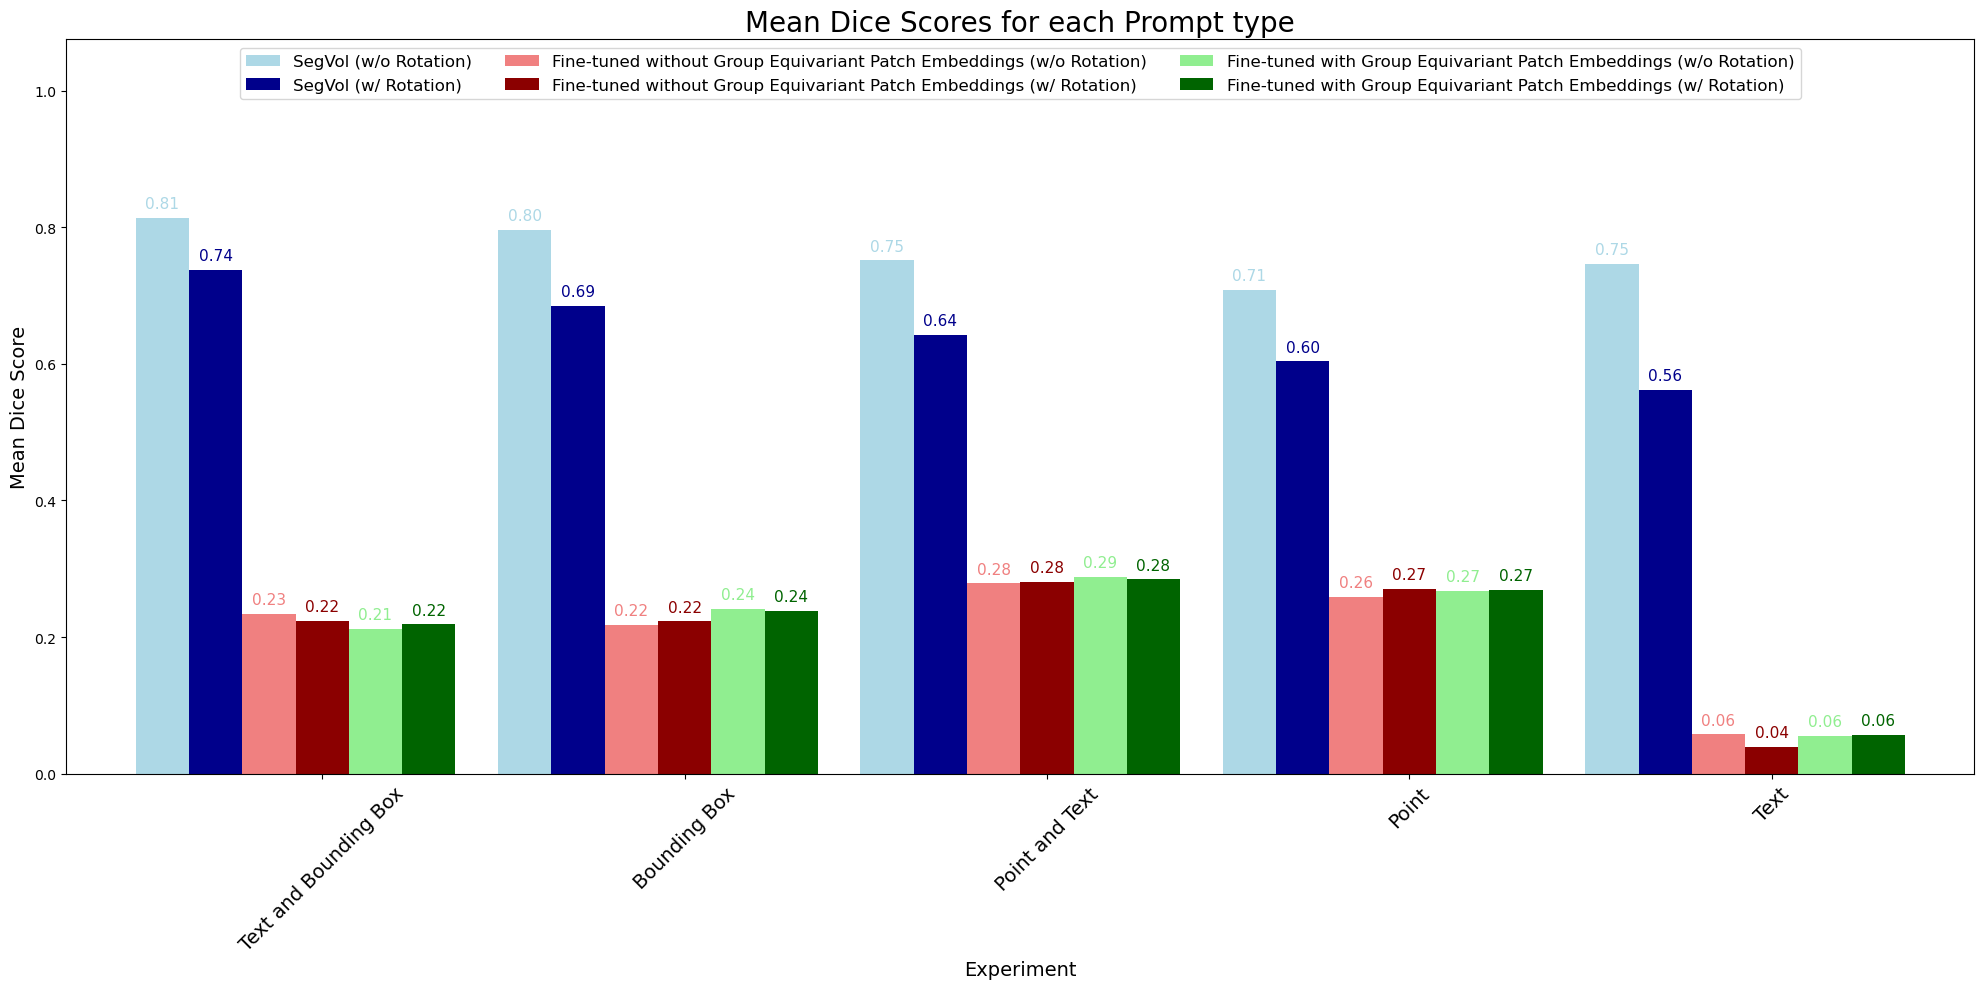

In [5]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

experiment_mapping = {
    2: 'Text and Bounding Box',
    3: 'Bounding Box',
    4: 'Point and Text',
    5: 'Point',
    6: 'Text',
}

dirs = ['SegVol', 'baseline_30_epochs', 'ft_25_epochs']  # List of directories

# Define colors and labels for each directory
colors = ['lightblue', 'darkblue', 'lightcoral', 'darkred', 'lightgreen', 'darkgreen']
labels = ['SegVol (w/o Rotation)', 'SegVol (w/ Rotation)', 
          'Fine-tuned without Group Equivariant Patch Embeddings (w/o Rotation)', 'Fine-tuned without Group Equivariant Patch Embeddings (w/ Rotation)',
          'Fine-tuned with Group Equivariant Patch Embeddings (w/o Rotation)', 'Fine-tuned with Group Equivariant Patch Embeddings (w/ Rotation)']

def load_data_from_directories(dirs):
    result_frames = []
    for directory in dirs:
        files = os.listdir(directory)
        files = [file for file in files if file.endswith('.csv')]
        
        for file in files:
            no_prefix = file.removeprefix('dice_scores_')
            experiment = no_prefix.split('_')[0]
            exp_nr = int(experiment[3])
            if exp_nr == 1:
                continue
            rotated = (experiment[4] == 'b')

            df = pd.read_csv(os.path.join(directory, file))
            df = df[df['Organ'] != 'Liver tumor']

            df['Rotated'] = rotated
            df['Experiment'] = exp_nr
            df['Directory'] = directory  # Add directory info

            dataset_codes = ['0007', '0018', '0020', '0021', '0023']
            scores = []
            for i, row in df.iterrows():
                valid_scores = [df.loc[i, c] for c in dataset_codes if df.loc[i, c] > 0]
                scores.append(np.mean(valid_scores) if valid_scores else np.nan)

            df['Score'] = scores
            result_frames.append(df)
    return pd.concat(result_frames, ignore_index=True)

combined_result_frame = load_data_from_directories(dirs)

# Calculate mean scores for each experiment across all datasets and organs
mean_scores_overall = combined_result_frame.groupby(['Experiment', 'Rotated', 'Directory'])['Score'].mean().unstack(['Rotated', 'Directory'])

# Plotting
plt.figure(figsize=(20, 10))
bar_width = 0.25  # Width of each bar
group_width = bar_width * len(dirs) * 2 + 0.2  # Width of each group of bars including a small space between groups
experiments = mean_scores_overall.index.get_level_values('Experiment').unique()
bar_positions = [i * group_width for i in range(len(experiments))]

pos_dict = {}
for i, directory in enumerate(dirs):
    pos_dict[(False, directory)] = [(-0.5 * len(dirs) * 2 + i * 2 + 0) * bar_width, colors[i * 2], labels[i * 2]]
    pos_dict[(True, directory)] = [(-0.5 * len(dirs) * 2 + i * 2 + 1) * bar_width, colors[i * 2 + 1], labels[i * 2 + 1]]

for exp_idx, experiment in enumerate(experiments):
    for key, (offset, color, label) in pos_dict.items():
        if key in mean_scores_overall.columns:
            positions = [bar_positions[exp_idx] + offset]
            plt.bar(positions, [mean_scores_overall.loc[experiment, key]], color=color, width=bar_width, label=label if exp_idx == 0 else "")

            # Annotate the bars with the mean values
            value = mean_scores_overall.loc[experiment, key]
            if not pd.isna(value):
                plt.text(positions[0], value + 0.01, f'{value:.2f}', ha='center', va='bottom', color=color, fontsize=11)

plt.xlabel('Experiment', fontsize=14)
plt.ylabel('Mean Dice Score', fontsize=14)
plt.title(f"Mean Dice Scores for each Prompt type", fontsize=20)
plt.xticks(bar_positions, [experiment_mapping[exp] for exp in experiments], rotation=45, fontsize=14)
plt.legend(ncol=3, loc='upper center', bbox_to_anchor=(0.5, 1.0), fontsize=12)
plt.xlim(-group_width + 0.5, -0.75 + bar_positions[-1] + group_width)
plt.ylim(0, 1.075)
plt.tight_layout()
plt.savefig(f'../../figures/dice_scores_per_prompt_{dirs[0]}_{dirs[1]}_{dirs[2]}.png')
plt.show()

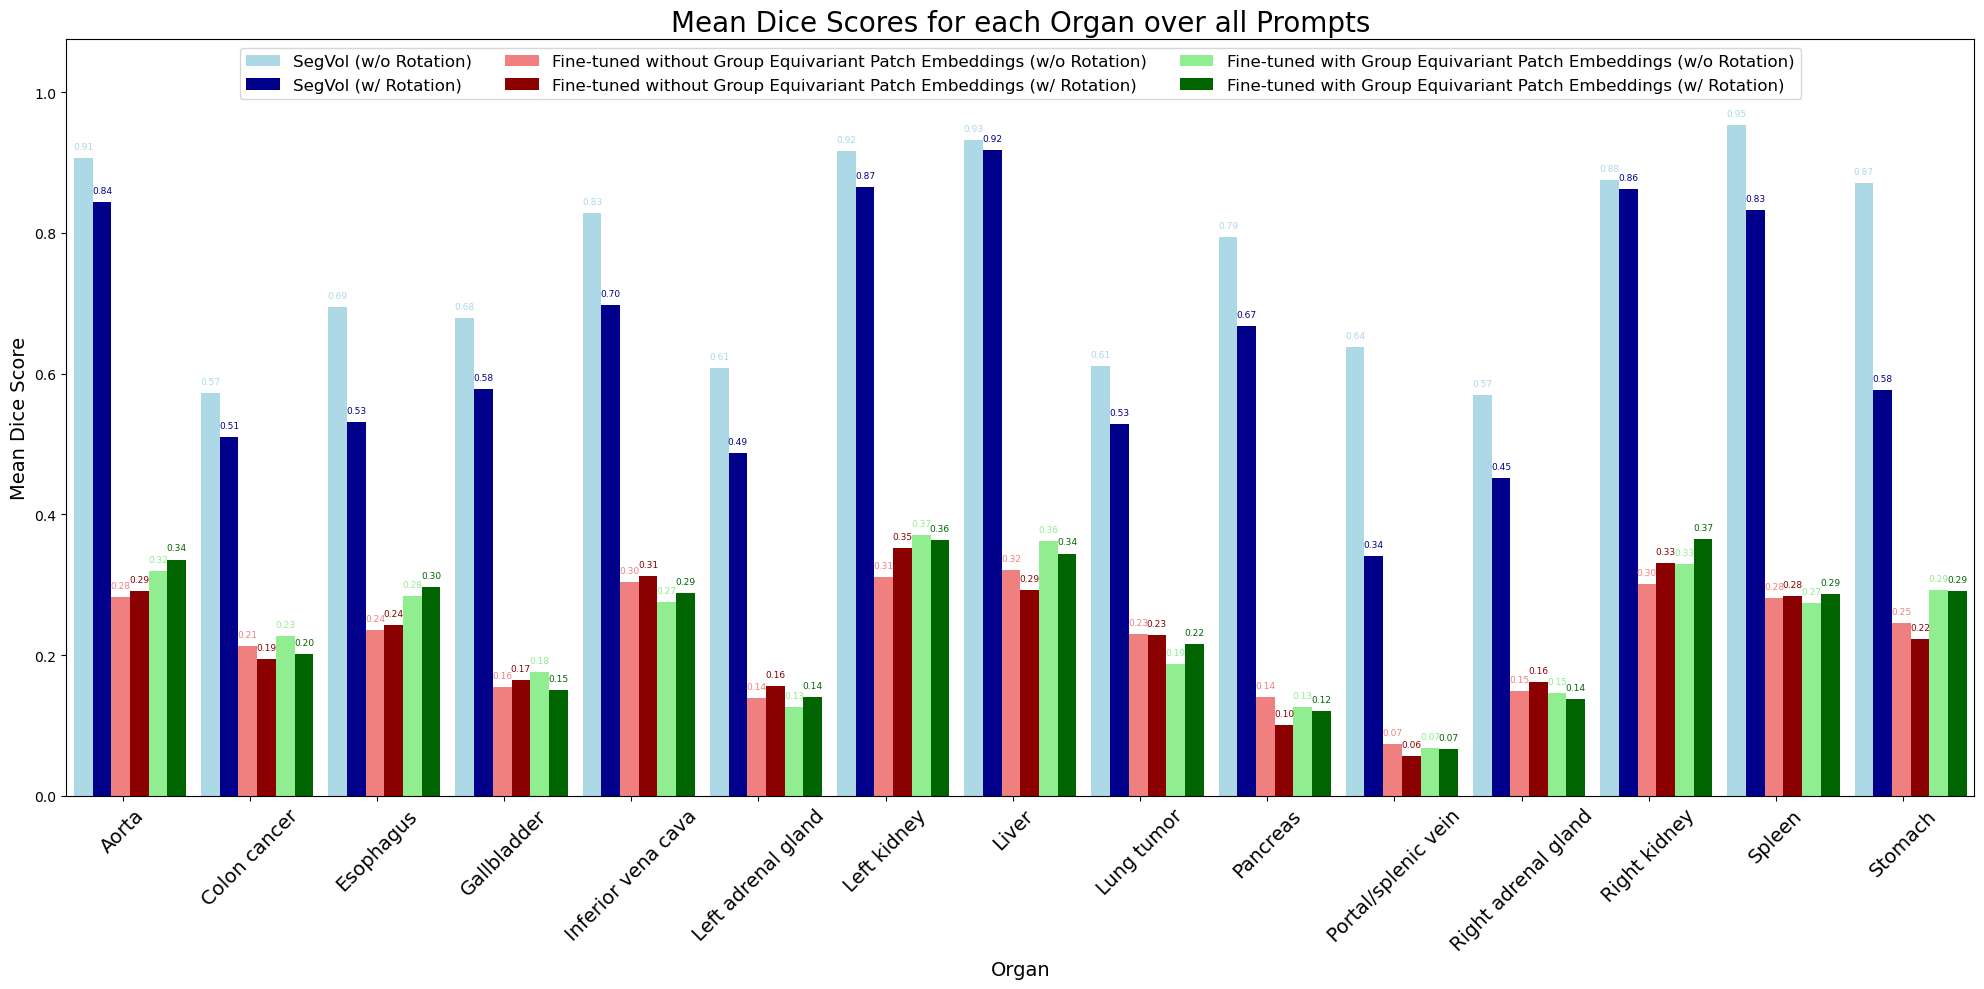

In [6]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

dirs = ['SegVol', 'baseline_30_epochs', 'ft_25_epochs']  # List of directories

# Define colors and labels for each directory
colors = ['lightblue', 'darkblue', 'lightcoral', 'darkred', 'lightgreen', 'darkgreen']
labels = ['SegVol (w/o Rotation)', 'SegVol (w/ Rotation)', 
          'Fine-tuned without Group Equivariant Patch Embeddings (w/o Rotation)', 'Fine-tuned without Group Equivariant Patch Embeddings (w/ Rotation)',
          'Fine-tuned with Group Equivariant Patch Embeddings (w/o Rotation)', 'Fine-tuned with Group Equivariant Patch Embeddings (w/ Rotation)']

def load_data_from_directories(dirs):
    result_frames = []
    for directory in dirs:
        files = os.listdir(directory)
        files = [file for file in files if file.endswith('.csv')]
        
        for file in files:
            no_prefix = file.removeprefix('dice_scores_')
            experiment = no_prefix.split('_')[0]
            exp_nr = int(experiment[3])
            if exp_nr == 1:
                continue
            rotated = (experiment[4] == 'b')

            df = pd.read_csv(os.path.join(directory, file))
            df = df[df['Organ'] != 'Liver tumor']

            df['Rotated'] = rotated
            df['Experiment'] = exp_nr
            df['Directory'] = directory  # Add directory info

            dataset_codes = ['0007', '0018', '0020', '0021', '0023']
            scores = []
            for i, row in df.iterrows():
                valid_scores = [df.loc[i, c] for c in dataset_codes if df.loc[i, c] > 0]
                scores.append(np.mean(valid_scores) if valid_scores else np.nan)

            df['Score'] = scores
            result_frames.append(df)
    return pd.concat(result_frames, ignore_index=True)

combined_result_frame = load_data_from_directories(dirs)

# Calculate mean scores for each organ across all experiments
mean_scores_overall = combined_result_frame.groupby(['Organ', 'Rotated', 'Directory'])['Score'].mean().unstack(['Rotated', 'Directory'])

# Plotting
plt.figure(figsize=(20, 10))
bar_width = 0.25  # Width of each bar
num_bars = len(dirs) * 2
group_width = bar_width * num_bars + 0.2  # Width of each group of bars including a small space between groups
organs = mean_scores_overall.index.get_level_values('Organ').unique()
bar_positions = [i * group_width for i in range(len(organs))]

pos_dict = {}
for i, directory in enumerate(dirs):
    pos_dict[(False, directory)] = [(i * 2) * bar_width, colors[i * 2], labels[i * 2]]
    pos_dict[(True, directory)] = [(i * 2 + 1) * bar_width, colors[i * 2 + 1], labels[i * 2 + 1]]

for organ_idx, organ in enumerate(organs):
    for key, (offset, color, label) in pos_dict.items():
        if key in mean_scores_overall.columns:
            positions = [bar_positions[organ_idx] + offset - (num_bars - 1) * bar_width / 2]
            plt.bar(positions, [mean_scores_overall.loc[organ, key]], color=color, width=bar_width, label=label if organ_idx == 0 else "")

            # Annotate the bars with the mean values
            value = mean_scores_overall.loc[organ, key]
            if not pd.isna(value):
                plt.text(positions[0], value + 0.01, f'{value:.2f}', ha='center', va='bottom', color=color, fontsize=6.5)

# Adjust tick positions to be centered between each group of bars
tick_positions = [pos - group_width / 2 + bar_width * num_bars / 2 for pos in bar_positions]

plt.xlabel('Organ', fontsize=14)
plt.ylabel('Mean Dice Score', fontsize=14)
plt.title(f"Mean Dice Scores for each Organ over all Prompts", fontsize=20)
plt.xticks(tick_positions, organs, rotation=45, fontsize=14)
plt.legend(ncol=3, loc='upper center', bbox_to_anchor=(0.5, 1.0), fontsize=12)
plt.xlim(-group_width / 2, bar_positions[-1] + group_width / 2)
plt.ylim(0, 1.075)
plt.tight_layout()
plt.savefig(f'../../figures/dice_scores_per_organ_all_prompts_{dirs[0]}_{dirs[1]}_{dirs[2]}.png')